# Analyse attrition ESN – Projet 4

# Table des matières

## 1. Introduction
- Objectif : Prédire l'attrition des employés (départs ESN)
- Contexte et usage du projet

## 2. Imports & Setup
- Importations des modules Python
- Réglages globaux (warnings, matplotlib, seaborn…)

## 3. Chargement des données
- Lecture des fichiers SIRH, sondage, évaluation
- Vérification des identifiants uniques et correspondance

## 4. Exploration & Nettoyage des Données
- Aperçu shape/head/types de chaque DataFrame
- Nettoyage : suppression, corrections, fusion

## 5. Fonctions Utilitaires
- Cellule dédiée : helpers de visualisation, scoring, feature engineering, encodage, ...
  - `plot_feature_distributions`
  - `add_salary_group_feature`, `create_salary_features`
  - `plot_heatmaps_cat`
  - Preprocessing pipeline helpers (`build_preprocessor`, `build_model_pipelines`…)

## 6. Feature Engineering
- Création des features :
  - Variables composites (poste-département, nouveau responsable…)
  - Transformation de salaire, score carrière, indice évolution
  - Découpage des salaires, features catégorielles

## 7. Visualisations Exploratoires
- Plot distributions, heatmaps, corrélations (Pearson)
- Analyse croisée features/target (explicatif visuel)

## 8. Préparation des jeux d’apprentissage
- Sélection/features list
- Encodage target
- Split train/test stratifié
- Pipeline preprocessing

## 9. Construction des Pipelines de modèles
- Modèles : Dummy, LogisticRegression, RandomForestClassifier, XGBoost, LightGBM
- Pipelines avec balancing natif et resampling (SMOTE/undersample)

## 10. Validation Croisée & Comparaisons
- Évaluation cross-validation (accuracy, recall, F1…)
- Matrices de confusion, courbes seuils
- Comparatif balanced/unbalanced, avec/without sampling

## 11. Optimisation des Hyperparamètres
- GridSearch sur LogisticRegression, XGBoost, (LightGBM)
- Affichage best params, best recall, F1

## 12. Évaluation Finale (Test Set)
- Prédiction sur jeu de test
- Calcul des scores, matrice de confusion, affichage grille

## 13. Interprétabilité & Explicabilité
- Importance des coefficients (logreg)
- SHAP global/local, Force plots

## 1. Introduction

**Objectif :**  
Prédire l'attrition des employés (départs volontaires) au sein de notre ESN à partir de données RH et d'évaluations internes.

**Contexte :**  
Ce projet vise à aider la direction et les managers à anticiper les risques de départ, optimiser la gestion des talents et mettre en place des actions de fidélisation ciblées grâce à l'analyse prédictive.

## 2. Imports & Setup

In [1]:
# Imports des modules principaux
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import math
import shap
#import shapash

#from dython.nominal import associations
from scipy.stats import chi2_contingency
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, fbeta_score, average_precision_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.special import expit  # sigmoid pour affichage proba

# Réglages globaux
import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated as an API")
warnings.filterwarnings('ignore', category=UserWarning)



## 3. Chargement des données

In [2]:
# Chargement des fichiers
df_sirh = pd.read_csv("../data/raw/extrait_sirh.csv")
df_sondage = pd.read_csv("../data/raw/extrait_sondage.csv")
df_eval = pd.read_csv("../data/raw/extrait_eval.csv")

# Vérification de l'unicité des identifiants
print("id_employee unique dans SIRH ?", df_sirh['id_employee'].is_unique)
print("eval_number unique dans eval ?", df_eval['eval_number'].is_unique)
print("code_sondage unique dans sondage ?", df_sondage['code_sondage'].is_unique)

# Extraction numérique des identifiants pour la correspondance
df_eval['eval_number_num'] = df_eval['eval_number'].str.extract(r'E_(\d+)').astype(int)

# Sets des valeurs pour l'intersection
valeurs_eval = set(df_eval['eval_number_num'].dropna().astype(int))
valeurs_id = set(df_sirh['id_employee'])
valeurs_sondage = set(df_sondage['code_sondage'])

intersection = valeurs_id & valeurs_eval & valeurs_sondage
print("Taille de l'intersection identifiants communs :", len(intersection))

print("Nombre unique dans SIRH :", len(valeurs_id))
print("Nombre unique dans eval :", len(valeurs_eval))
print("Nombre unique dans sondage :", len(valeurs_sondage))

# Fusion des jeux de données via l'identifiant commun
df_central = (
    df_sirh.merge(
        df_eval.assign(eval_number_num=df_eval['eval_number'].str.extract(r'E_(\d+)').astype(int)),
        left_on='id_employee', right_on='eval_number_num'
    )
    .merge(df_sondage, left_on='id_employee', right_on='code_sondage')
)

# Aperçu du résultat
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)  # Toutes les colonnes visibles

display(df_central)


id_employee unique dans SIRH ? True
eval_number unique dans eval ? True
code_sondage unique dans sondage ? True
Taille de l'intersection identifiants communs : 1470
Nombre unique dans SIRH : 1470
Nombre unique dans eval : 1470
Nombre unique dans sondage : 1470


,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,eval_number_num,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4,2,3,2,4,1,1,E_1,3,Oui,11 %,1,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7,3,2,2,2,4,3,E_2,4,Non,23 %,2,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0,4,2,1,3,2,3,E_4,3,Oui,15 %,4,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7,4,3,1,3,3,3,E_5,3,Oui,11 %,5,Non,0,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2,1,3,1,2,4,3,E_7,3,Non,12 %,7,Non,1,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,2061,36,M,2571,Marié(e),Consulting,Consultant,4,80,17,5,2,3,4,2,4,3,3,E_2061,3,Non,17 %,2061,Non,1,3,1,2061,23,2,Transformation Digitale,Y,Frequent,0,3
1466,2062,39,M,9991,Marié(e),Consulting,Manager,4,80,9,7,7,4,2,3,1,1,3,E_2062,3,Non,15 %,2062,Non,1,5,1,2062,6,1,Transformation Digitale,Y,Occasionnel,1,7
1467,2064,27,M,6142,Marié(e),Consulting,Tech Lead,1,80,6,6,2,2,4,2,2,2,3,E_2064,4,Oui,20 %,2064,Non,1,0,1,2064,4,3,Infra & Cloud,Y,Occasionnel,0,3
1468,2065,49,M,5390,Marié(e),Commercial,Cadre Commercial,2,80,17,9,6,4,2,2,2,4,2,E_2065,3,Non,14 %,2065,Non,0,3,1,2065,2,3,Transformation Digitale,Y,Frequent,0,8


## 4. Exploration & Nettoyage des Données

In [3]:
# --- Aperçu global des dataframes
for name, df in [('SIRH', df_sirh), ('Sondage', df_sondage), ('Evaluation', df_eval)]:
    print(f"\n>>> Aperçu du DataFrame : {name}")
    print(f"Shape : {df.shape}")
    display(df.head(3))
    print(df.dtypes)


>>> Aperçu du DataFrame : SIRH
Shape : (1470, 12)


,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0


id_employee                        int64
age                                int64
genre                             object
revenu_mensuel                     int64
statut_marital                    object
departement                       object
poste                             object
nombre_experiences_precedentes     int64
nombre_heures_travailless          int64
annee_experience_totale            int64
annees_dans_l_entreprise           int64
annees_dans_le_poste_actuel        int64
dtype: object

>>> Aperçu du DataFrame : Sondage
Shape : (1470, 12)


,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0


a_quitte_l_entreprise                  object
nombre_participation_pee                int64
nb_formations_suivies                   int64
nombre_employee_sous_responsabilite     int64
code_sondage                            int64
distance_domicile_travail               int64
niveau_education                        int64
domaine_etude                          object
ayant_enfants                          object
frequence_deplacement                  object
annees_depuis_la_derniere_promotion     int64
annes_sous_responsable_actuel           int64
dtype: object

>>> Aperçu du DataFrame : Evaluation
Shape : (1470, 11)


,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,eval_number_num
0,2,3,2,4,1,1,E_1,3,Oui,11 %,1
1,3,2,2,2,4,3,E_2,4,Non,23 %,2
2,4,2,1,3,2,3,E_4,3,Oui,15 %,4


satisfaction_employee_environnement           int64
note_evaluation_precedente                    int64
niveau_hierarchique_poste                     int64
satisfaction_employee_nature_travail          int64
satisfaction_employee_equipe                  int64
satisfaction_employee_equilibre_pro_perso     int64
eval_number                                  object
note_evaluation_actuelle                      int64
heure_supplementaires                        object
augementation_salaire_precedente             object
eval_number_num                               int64
dtype: object


Description de SIRH
| feature | description | remarques |
|---|---|---|
| **id_employee** | identifiant unique | <span style="color: green; font-weight: bold;">entier numérique, compris entre 1 et 2068, à utiliser en cle de jointure.</span> |
| **age** | âge de l'employé en années | entier numérique, compris entre 18 et 60 |
| **genre** | Masculin ou Féminin | M ou F | 
| **revenu_mensuel** | salaire en euros | entier numérique, compris entre 1009 et 19999 |
| **statut_marital** | statut marital | Marié(e), Divorcé(e) ou Célibataire |
| **departement** | service du salarié | Consulting, Commercial ou Ressources Humaines |
| **poste** | poste du salarié | 9 valeurs posibles |
| **nombre_experiences_precedentes** | Entreprises précedentes avant le poste actuel | entier numérique, compris entre 0 et 9 |
| **nombre_heures_travailless** | heures effectuées par semaine | <span style="color: red; font-weight: bold;">toutes les valeurs sont à 80, incohérent, ne pas conserver</span> |
| **annee_experience_totale** | nombre d'années dans le monde du travail | entier numerique, compris entre 0 et 40 |
| **annees_dans_l_entreprise**¨ | ancienneté dans l'entreprise | entier numérique, compris entre 0 et 40 |
| **annees_dans_le_poste_actuel** | ancienneté dans le poste | entier numérique, compris entre 0 et 18 |

Toutes les données semblent cohérentes, excepté le nombre d'heures par semaine.

Description de Sondage
| feature | description | remarques |
|---|---|---|
| **a_quitte_l_entreprise** | Démission | Oui ou Non |
| **nombre_participation_pee** | Participations au Plan d’Épargne Entreprise | Entier numérique, compris entre de 0 et 3 |
| **nb_formations_suivies** | Formations suivies | Entier numérique, compris entre de 0 et 6 |
| **nombre_employee_sous_responsabilite** | Management | <span style="color: red; font-weight: bold;">Toujours 1, pas cohérent, ne pas conserver</span> |
| **code_sondage** | Identifiant unique du sondage | <span style="color: green; font-weight: bold;">Entier unique de 1 à 2068, à utiliser comme clef de jointure</span> |
| **distance_domicile_travail** | Distance domicile-travail (km) | Entier numérique, compris entre de 1 et 29 |
| **niveau_education** | Niveau d’éducation atteint | Entier numérique, compris entre de 1 et 5 |
| **domaine_etude** | Domaine d’étude principal | Infra & Cloud, Transformation Digitale, Entrepreunariat, Marketing, Ressources Humaines ou Autre |
| **ayant_enfants** | A des enfants ? | <span style="color: red; font-weight: bold;">Toujours Y, peu probable, pas utile, ne pas conserver</span> |
| **frequence_deplacement** | Fréquence des déplacements professionnels | Occasionnel, fréquent ou Aucun |
| **annees_depuis_la_derniere_promotion** | Années depuis la dernière promotion | Entier numérique, compris entre de 0 et 15 |
| **annes_sous_responsable_actuel** | Années avec le responsable actuel | Entier numérique, compris entre de 0 et 17 |

Toutes les données semblent cohérentes, excepté nombre_employee_sous_responsabilite et ayant_enfants.

Description de Evaluation
| feature | description | remarques |
|---|---|---|
| **satisfaction_employee_environnement** | Satisfaction vis-à-vis de l’environnement de travail | entier numérique, compris entre 1 et 4 |
| **note_evaluation_precedente** | Note de la précédente évaluation | entier numérique, compris entre 1 et 4 |
| **niveau_hierarchique_poste** | Niveau hiérarchique du poste | entier numérique, compris entre 1 et 5 |
| **satisfaction_employee_nature_travail** | Satisfaction sur la nature du travail | entier numérique, compris entre 1 et 4 |
| **satisfaction_employee_equipe** | Satisfaction par rapport à l’équipe | entier numérique, compris entre 1 et 4 |
| **satisfaction_employee_equilibre_pro_perso** | Satisfaction équilibre pro/perso | entier numérique, compris entre 1 et 4 |
| **eval_number** | Identifiant unique de l’évaluation | chaîne de type 'E_X',<br><span style="color: green; font-weight: bold;">à convertir en valeur numérique pour utiliser comme clef de jointure</span> |
| **note_evaluation_actuelle** | Note de l’évaluation globale | entier numérique, compris entre 3 et 4 |
| **heure_supplementaires** | A effectué des heures supplémentaires | Oui ou Non |
| **augementation_salaire_precedente** | augmentation précédente exprimée en pourcentage | 15 modalités, <span style="color: red; font-weight: bold;">type objet à convertir en valeur numérique</span> |

Toutes les données semblent cohérentes, excepté augementation_salaire_precedente à convertir en valeur numérique.

In [4]:
# --- Suppression/renommage de colonnes inutiles ou redondantes après fusion
colonnes_a_supprimer = [
    'id_employee', 'eval_number', 'eval_number_num', 'code_sondage',
    'nombre_heures_travailless', 'nombre_employee_sous_responsabilite', 'ayant_enfants'
]

df_central = df_central.drop(columns=colonnes_a_supprimer, errors='ignore')

print("\nShape du DataFrame central nettoyé :", df_central.shape)
display(df_central.head(5))


Shape du DataFrame central nettoyé : (1470, 28)


,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,8,6,4,2,3,2,4,1,1,3,Oui,11 %,Oui,0,0,1,2,Infra & Cloud,Occasionnel,0,5
1,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,10,10,7,3,2,2,2,4,3,4,Non,23 %,Non,1,3,8,1,Infra & Cloud,Frequent,1,7
2,37,M,2090,Célibataire,Consulting,Consultant,6,7,0,0,4,2,1,3,2,3,3,Oui,15 %,Oui,0,3,2,2,Autre,Occasionnel,0,0
3,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,8,8,7,4,3,1,3,3,3,3,Oui,11 %,Non,0,3,3,4,Infra & Cloud,Frequent,3,0
4,27,M,3468,Marié(e),Consulting,Consultant,9,6,2,2,1,3,1,2,4,3,3,Non,12 %,Non,1,3,2,1,Transformation Digitale,Occasionnel,2,2


## 5. Fonctions Utilitaires

### Helpers de visualisation, feature engineering et encodage

In [5]:
# --- Visualisation des distributions de features (num et cat) selon la cible
def plot_feature_distributions(df, features, target):
    num_cols = [col for col in features if df[col].dtype in ['int64', 'float64']]
    cat_cols = [col for col in features if col not in num_cols]
    vals = list(df[target].unique())
    if 'Oui' in vals and 'Non' in vals:
        vals = ['Non', 'Oui']
    # Numériques
    if num_cols:
        nrows = math.ceil(len(num_cols) / 2)
        fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(14, 4 * nrows))
        axes = axes.flatten()
        for idx, col in enumerate(num_cols):
            for i, val in enumerate(vals):
                axes[idx].hist(
                    df[df[target] == val][col],
                    bins=30,
                    label=str(val),
                    color=('C1' if val == 'Oui' else 'C0'),
                    alpha=1
                )
            axes[idx].set_title(col)
            axes[idx].set_ylabel('Effectif')
            axes[idx].legend(title=target)
        for idx in range(len(num_cols), len(axes)):
            axes[idx].set_visible(False)
        plt.tight_layout()
        plt.show()
    # Catégorielles
    if cat_cols:
        nrows = math.ceil(len(cat_cols) / 2)
        fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(14, 4 * nrows))
        for idx, col in enumerate(cat_cols):
            ax = axes[idx // 2, idx % 2]
            ct = pd.crosstab(df[col], df[target])
            modalities = ct.index.tolist()
            x = np.arange(len(modalities))
            for i, val in enumerate(['Non', 'Oui']):
                bar = ax.bar(x, ct[val], width=0.8, label=val,
                             color=('C1' if val == 'Oui' else 'C0'),
                             alpha=1, zorder=2+i)
            ax.set_xticks(x)
            ax.set_xticklabels(modalities, rotation=45, ha='right')
            ax.set_title(col)
            ax.set_ylabel('Effectif')
            ax.legend(title=target)
        for idx in range(len(cat_cols), axes.size):
            axes.flatten()[idx].set_visible(False)
        plt.tight_layout()
        plt.show()

# --- Fonction pour bel affichage des scores
def pretty_metrics(models, X_test, y_test):
    rows = []
    for name, model in models.items():
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred) * 100
        prec = precision_score(y_test, y_pred, zero_division=0) * 100
        rec = recall_score(y_test, y_pred) * 100
        f1 = f1_score(y_test, y_pred) * 100
        f2 = fbeta_score(y_test, y_pred, beta=2, zero_division=0) * 100
        pr_auc = average_precision_score(y_test, model.predict_proba(X_test)[:,1]) * 100 if hasattr(model, "predict_proba") else None
        rows.append({
            "Modèle": name,
            "Accuracy (%)": f"{acc:.1f}",
            "Précision (%)": f"{prec:.1f}",
            "Rappel (%)": f"{rec:.1f}",
            "F1 (%)": f"{f1:.1f}",
            "F2 (%)": f"{f2:.1f}",
            "PR-AUC (%)": f"{pr_auc:.1f}" if pr_auc is not None else "N/A"
        })
    df = pd.DataFrame(rows)
    display(df.set_index('Modèle'))

# --- Pareil mais avec les seuils ---
def metrics_table(y_true, y_pred, y_proba, model_name, seuil):
    acc = accuracy_score(y_true, y_pred) * 100
    prec = precision_score(y_true, y_pred, zero_division=0) * 100
    rec = recall_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred) * 100
    f2 = fbeta_score(y_true, y_pred, beta=2, zero_division=0) * 100
    pr_auc = average_precision_score(y_true, y_proba) * 100
    return {
        "Modèle": model_name,
        "Seuil": f"{seuil:.2f}",
        "Accuracy (%)": f"{acc:.1f}",
        "Précision (%)": f"{prec:.1f}",
        "Rappel (%)": f"{rec:.1f}",
        "F1 (%)": f"{f1:.1f}",
        "F2 (%)": f"{f2:.1f}",
        "PR-AUC (%)": f"{pr_auc:.1f}"
    }
    
# --- Fonction de découpage en groupes de salaires
def add_salary_group_feature(df, group_cols=None, col_revenu='revenu_mensuel', feature_name='salary_group', labels=None):
    if labels is None:
        labels = ["Très bas", "Bas", "Moyen", "Haut"]
    if group_cols is not None:
        q1 = df.groupby(group_cols)[col_revenu].transform(lambda x: x.quantile(0.25))
        mediane = df.groupby(group_cols)[col_revenu].transform('median')
        q3 = df.groupby(group_cols)[col_revenu].transform(lambda x: x.quantile(0.75))
    else:
        q1 = pd.Series(df[col_revenu].quantile(0.25), index=df.index)
        mediane = pd.Series(df[col_revenu].median(), index=df.index)
        q3 = pd.Series(df[col_revenu].quantile(0.75), index=df.index)
    conditions = [
        df[col_revenu] < q1,
        (df[col_revenu] >= q1) & (df[col_revenu] < mediane),
        (df[col_revenu] > q3),
        (df[col_revenu] >= mediane) & (df[col_revenu] <= q3)
    ]
    df[feature_name] = np.select(conditions, labels, default='Moyen')
    return df

def create_salary_features(df, col_revenu='revenu_mensuel'):
    labels = ["Très bas", "Bas", "Moyen", "Haut"]
    df = add_salary_group_feature(df, group_cols=None, col_revenu=col_revenu, feature_name="salaire_cat", labels=labels)
    df["salaire_cat_eq"] = pd.cut(df[col_revenu], bins=4, labels=labels)
    df = add_salary_group_feature(df, group_cols=['poste_departement'], col_revenu=col_revenu, feature_name="position_salaire_poste", labels=labels)
    df = add_salary_group_feature(df, group_cols=['poste_departement', 'annees_dans_le_poste_actuel'], col_revenu=col_revenu, feature_name="position_salaire_poste_anc", labels=labels)
    return df

# --- Génération Heatmap pour les groupes de salaires vs variable cible
def plot_heatmaps_cat(df, row_cat, col_cats, target, ordre_labels, cmap, titles, xlabels, ylabel):
    fig, axs = plt.subplots(1, len(col_cats), figsize=(8*len(col_cats), 6))
    for i, col in enumerate(col_cats):
        ct = (
            df
            .groupby([row_cat, col, target], observed=True)
            .size()
            .unstack(fill_value=0)
        )
        # On force la présence des deux colonnes ['Oui', 'Non'] pour tous les croisements
        for val in ['Oui', 'Non']:
            if val not in ct.columns:
                ct[val] = 0
        # Pourcentage de Oui par croisement (xx%)
        hm = (ct['Oui'] / (ct['Oui'] + ct['Non']) * 100).fillna(0)

        # Conversion en DataFrame carré si besoin
        if isinstance(hm, pd.Series):
            hm = hm.unstack().fillna(0)

        # Puis reindex uniquement si possible
        hm = hm.reindex(index=ordre_labels, columns=ordre_labels)

        sns.heatmap(hm, cmap=cmap, annot=True, fmt='.0f', ax=axs[i])
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(xlabels[i])
        axs[i].set_ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# --- Preprocessing pipeline helpers
def build_preprocessor(features_num, features_ord, features_cat, features_bin, ord_mappings=None):
    ord_pipe = Pipeline([
        ('ordinal', OrdinalEncoder(categories=ord_mappings)),
        ('scaler', StandardScaler())
    ])
    bin_pipe = Pipeline([
        ('label', OrdinalEncoder())
    ])
    num_pipe = StandardScaler()
    cat_pipe = OneHotEncoder(handle_unknown='ignore')
    return ColumnTransformer([
        ('num', num_pipe, features_num),
        ('ord', ord_pipe, features_ord),
        ('cat', cat_pipe, features_cat),
        ('bin', bin_pipe, features_bin)
    ])

def build_model_pipelines(models, preprocessor):
    return {name: Pipeline([
        ('preprocess', preprocessor),
        ('clf', clf)
    ]) for name, clf in models.items()}


### Helpers de scoring, validation croisée et matrice de confusion

In [20]:
# --- Scoring multi-métriques (pour cross-validation) ---

# 1. Scale_pos_weight pour XGB
n_neg = (y_train == 0).sum()
n_pos = (y_train == 1).sum()
scale_pos_weight = n_neg / n_pos

def get_scoring_dict(pos_label=1):
    return {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, pos_label=pos_label, zero_division=0),
        'recall': make_scorer(recall_score, pos_label=pos_label, zero_division=0),
        'f1': make_scorer(f1_score, pos_label=pos_label, zero_division=0),
        'f2': make_scorer(fbeta_score, beta=2, pos_label=pos_label, zero_division=0),
        'pr_auc': 'average_precision'
    }

def crossval_score_models(pipelines, X, y, cv=5, scoring=None):
    results = []
    for name, pipe in pipelines.items():
        cvres = cross_validate(pipe, X, y, cv=cv, scoring=scoring)
        results.append({
            'Model': name,
            'Accuracy': cvres['test_accuracy'].mean(),
            'Precision': cvres['test_precision'].mean(),
            'Recall': cvres['test_recall'].mean(),
            'F1': cvres['test_f1'].mean(),
            'F2': cvres['test_f2'].mean() if 'test_f2' in cvres else None,
            'PR-AUC': cvres['test_pr_auc'].mean() if 'test_pr_auc' in cvres else None
        })
    df = pd.DataFrame(results)
    for col in ['Accuracy', 'Precision', 'Recall', 'F1', 'F2', 'PR-AUC']:
        if col in df.columns:
            df[col] = (df[col] * 100).round(1)
    return df

def find_optimal_threshold_cv(model, X_train, y_train, beta=2, n_splits=5):
    thresholds = np.linspace(0, 1, 101)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_thresholds = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_fold_train, y_fold_train)
        y_proba_val = model.predict_proba(X_fold_val)[:, 1]
        f2_scores = [fbeta_score(y_fold_val, (y_proba_val >= t), beta=beta) for t in thresholds]
        best_idx = np.argmax(f2_scores)
        best_thresholds.append(thresholds[best_idx])
    return np.mean(best_thresholds)  # seuil optimal moyen CV


# --- Matrice de confusion cross-validation (sans changement) ---
def confusion_matrix_cv(pipeline, X, y, cv=5, labels_txt=['Non','Oui']):
    y_pred = cross_val_predict(pipeline, X, y, cv=cv)
    cm = confusion_matrix(y, y_pred, labels=[0, 1])
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_txt, yticklabels=labels_txt)
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.title("Matrice de confusion - Cross-Val (train set)")
    plt.show()


### Helpers pour resampling

In [7]:
# --- Helper: pipeline avec resampling (SMOTE ou under)
def build_resampling_pipeline(preprocessor, model, oversample=None, undersample=None):
    steps = [('preprocess', preprocessor)]
    if oversample:
        steps.append(('oversample', oversample))
    if undersample:
        steps.append(('undersample', undersample))
    steps.append(('clf', model))
    return ImbPipeline(steps)

def make_models(preprocessor, balance_logreg, balance_xgb, resampling=None, y_train=None):
    n_negative = (y_train == 0).sum()
    n_positive = (y_train == 1).sum()
    scale_pos_weight = n_negative / n_positive if (balance_xgb and n_positive > 0) else 1
    models = {
        'LogisticRegression': LogisticRegression(solver='liblinear', class_weight='balanced' if balance_logreg else None),
        'XGBoost': XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=42),
        'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42)
    }
    pipelines = {}
    for name, model in models.items():
        if resampling == 'smote':
            pipe = build_resampling_pipeline(preprocessor, model, oversample=SMOTE())
        elif resampling == 'undersample':
            pipe = build_resampling_pipeline(preprocessor, model, undersample=RandomUnderSampler())
        else:
            pipe = build_resampling_pipeline(preprocessor, model)  # no resampling
        pipelines[name] = pipe
    return pipelines


## 5bis. Analyse exploratoire

Avant la création des nouvelles features, nous procédons à une exploration visuelle et statistique du jeu de données fusionné :
- Aperçu des distributions des variables principales
- Recherche de valeurs aberrantes et d’éventuels biais
- Analyse des corrélations entre variables
- Inspection de la cible à prédire ("a_quitte_l_entreprise")


### Définition de la Target
On souhaite ici endiguer un phénomène de Turn-Over, on veut donc prédire ou expliquer les démissions.
La Target sera donc "**a_quitte_l_entreprise**"

In [8]:
target = 'a_quitte_l_entreprise'

### Liste des features initiales

In [9]:
features_init = [
    'age',
    'genre',
    'revenu_mensuel',
    'statut_marital',
    'departement',
    'poste',
    'nombre_experiences_precedentes',
    'annee_experience_totale',
    'annees_dans_l_entreprise',
    'annees_dans_le_poste_actuel',
    'satisfaction_employee_environnement',
    'note_evaluation_precedente',
    'niveau_hierarchique_poste',
    'satisfaction_employee_nature_travail',
    'satisfaction_employee_equipe',
    'satisfaction_employee_equilibre_pro_perso',
    'heure_supplementaires',
    'augementation_salaire_precedente',
    'a_quitte_l_entreprise',
    'nombre_participation_pee',
    'nb_formations_suivies',
    'distance_domicile_travail',
    'niveau_education',
    'domaine_etude',
    'frequence_deplacement',
    'annees_depuis_la_derniere_promotion',
    'annes_sous_responsable_actuel',
    'note_evaluation_actuelle'
]

Non    1233
Oui     237
Name: a_quitte_l_entreprise, dtype: int64


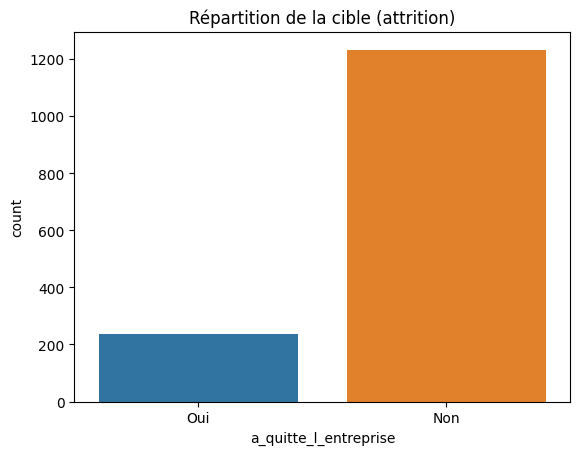

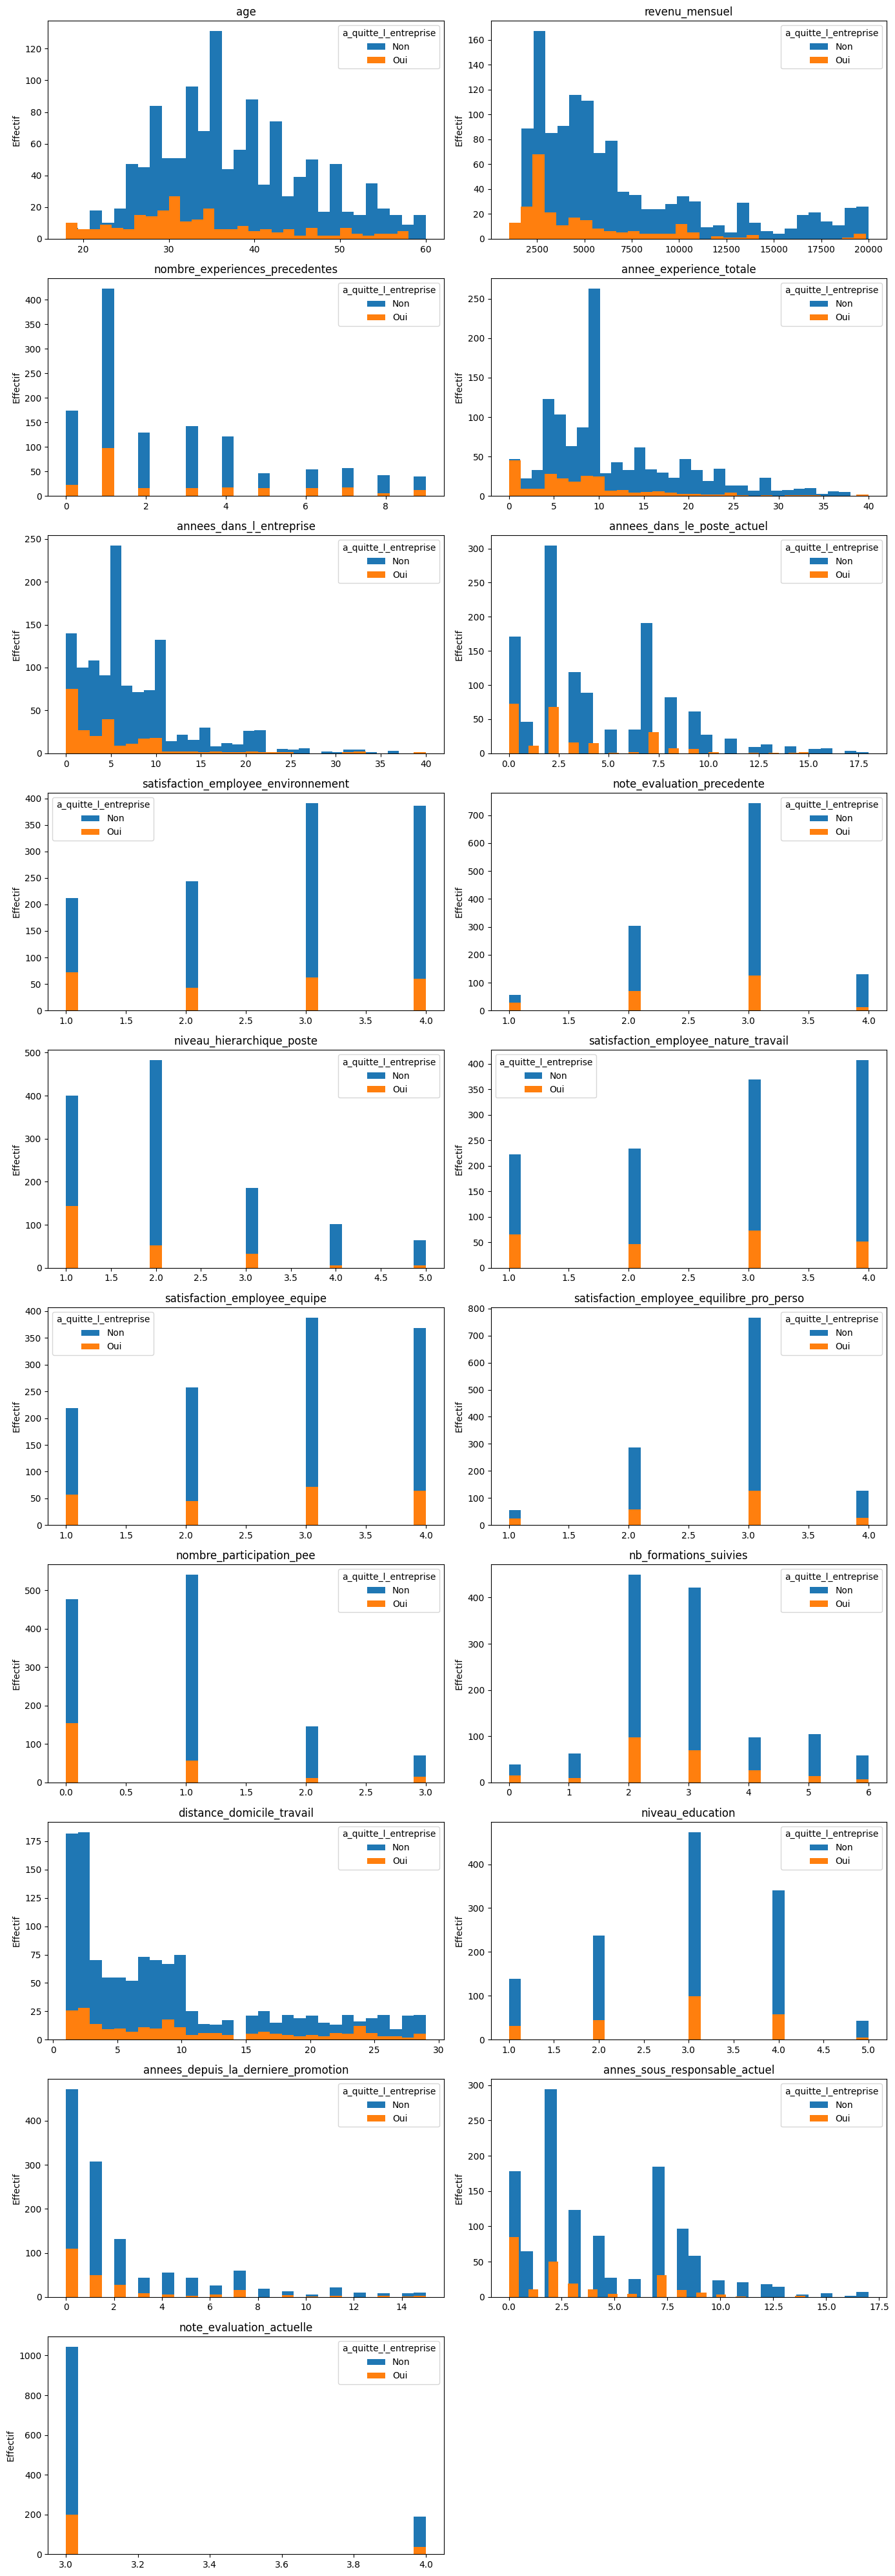

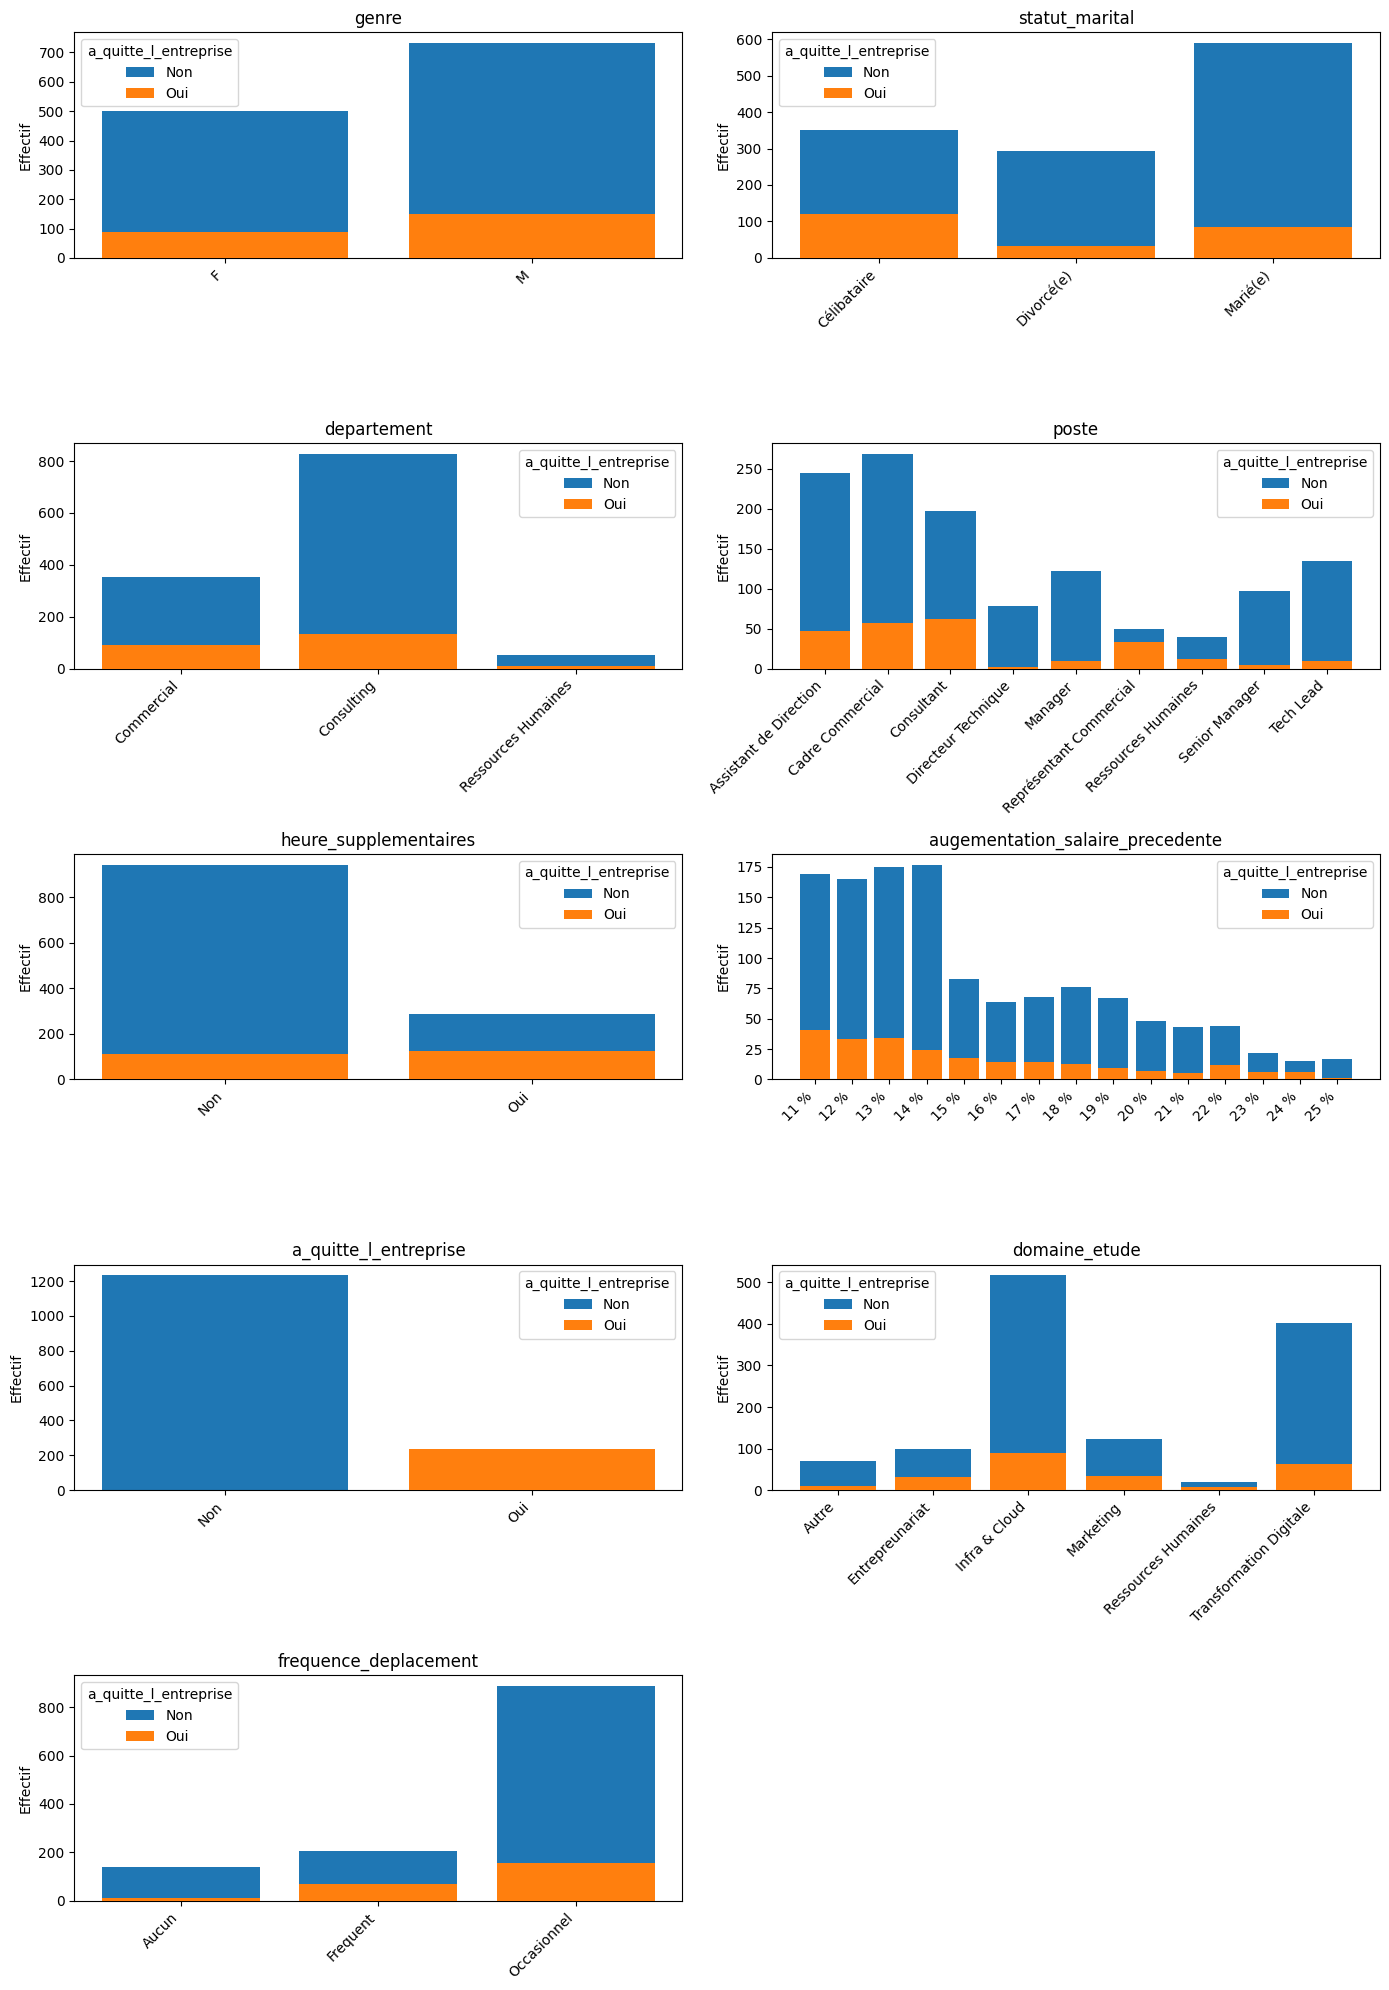

Skipping non-numeric feature: poste
Skipping non-numeric feature: departement


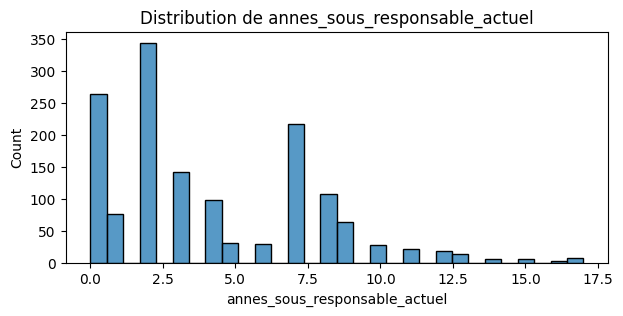

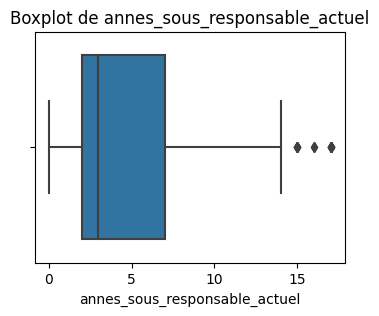

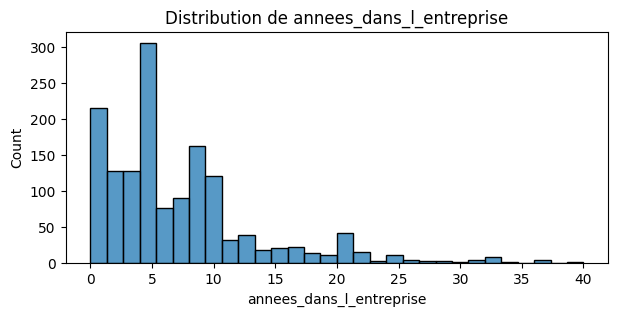

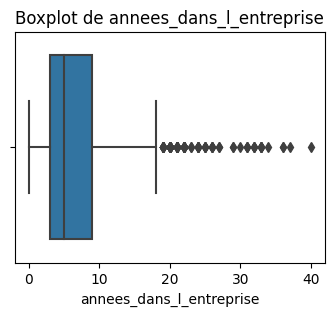

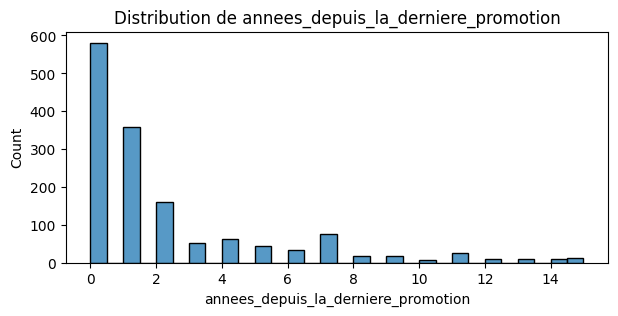

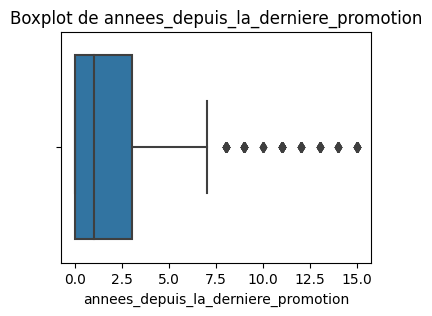

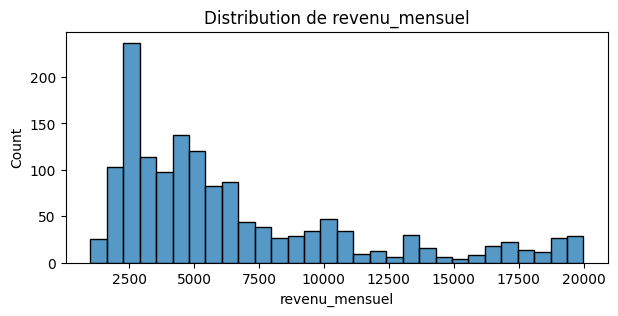

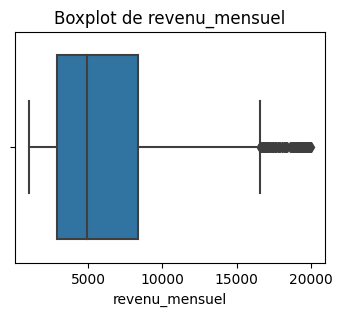

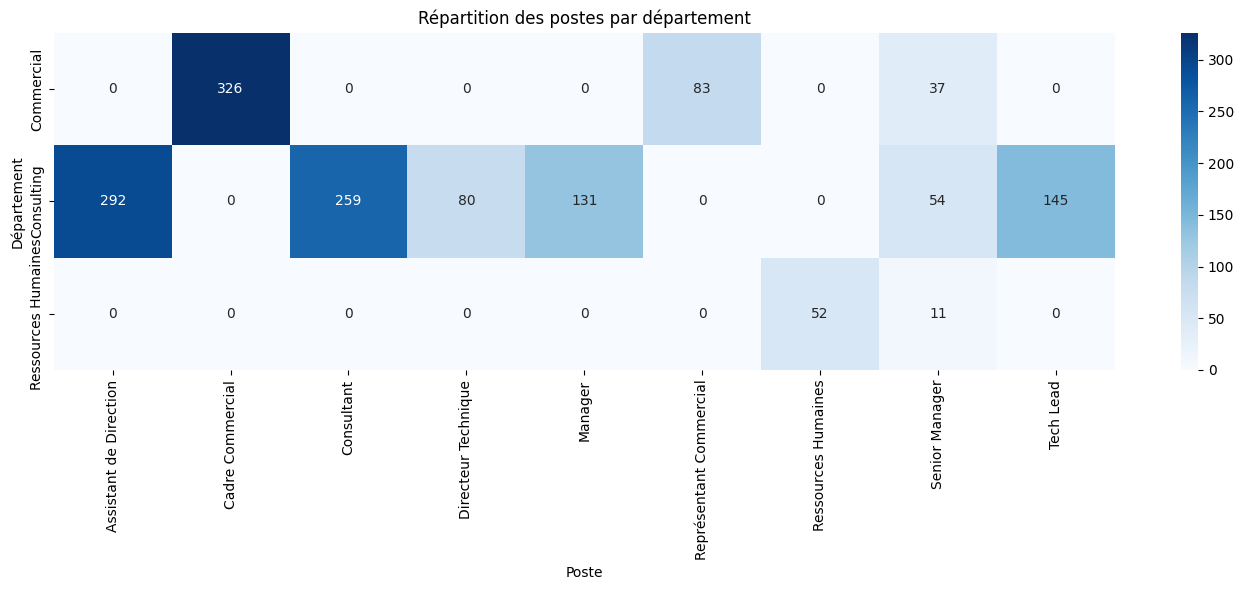

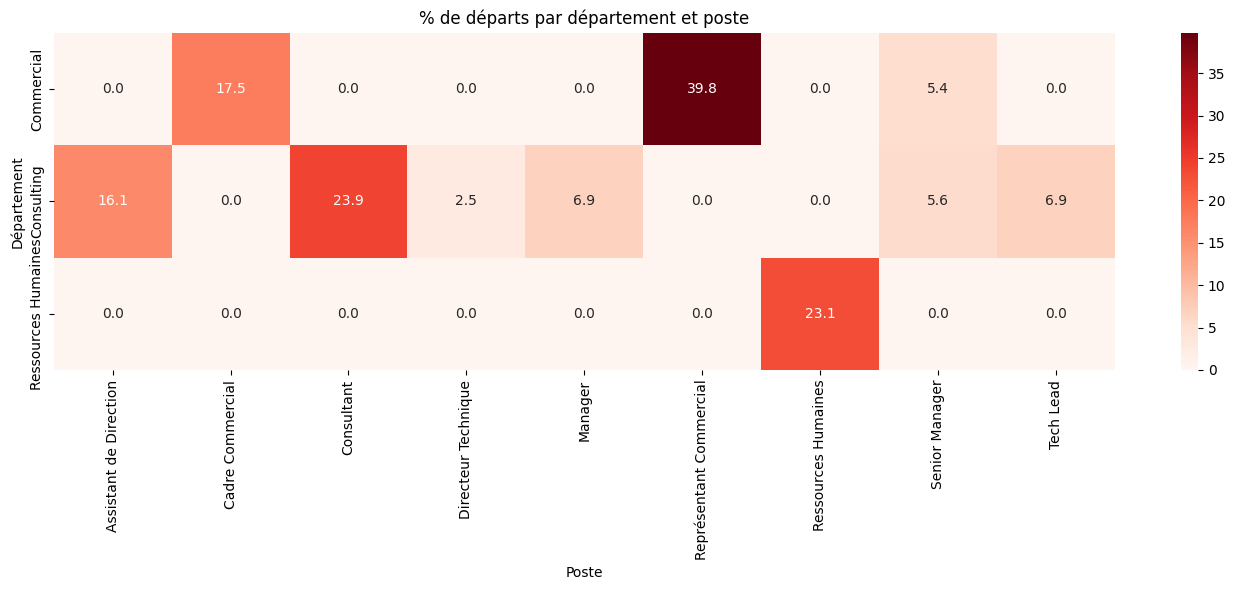

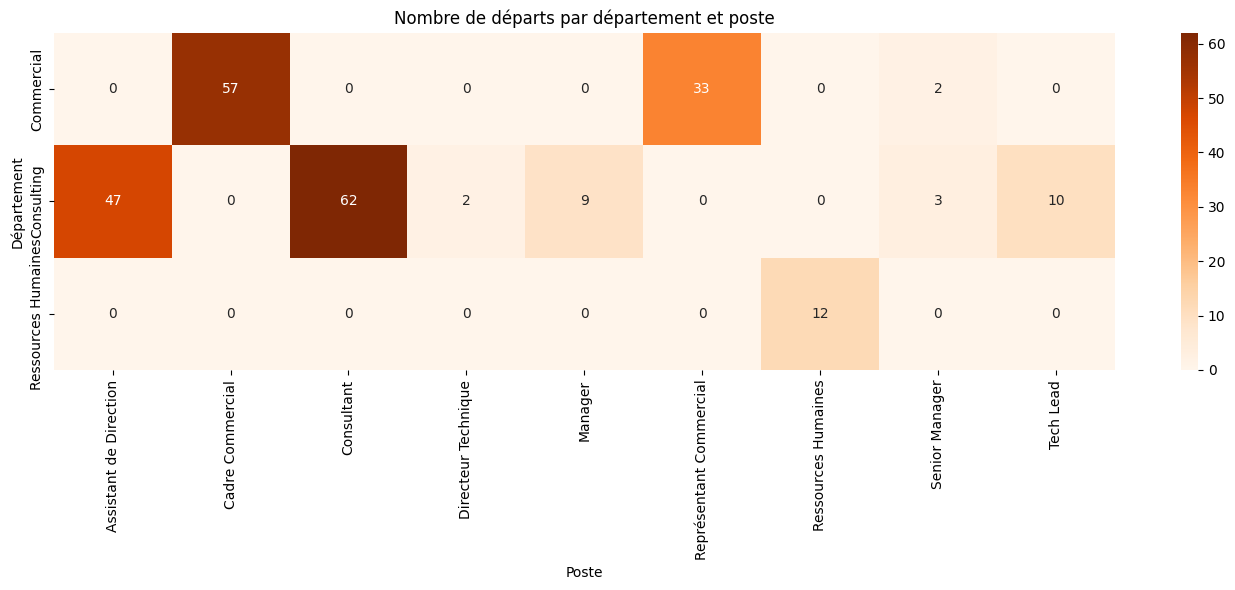

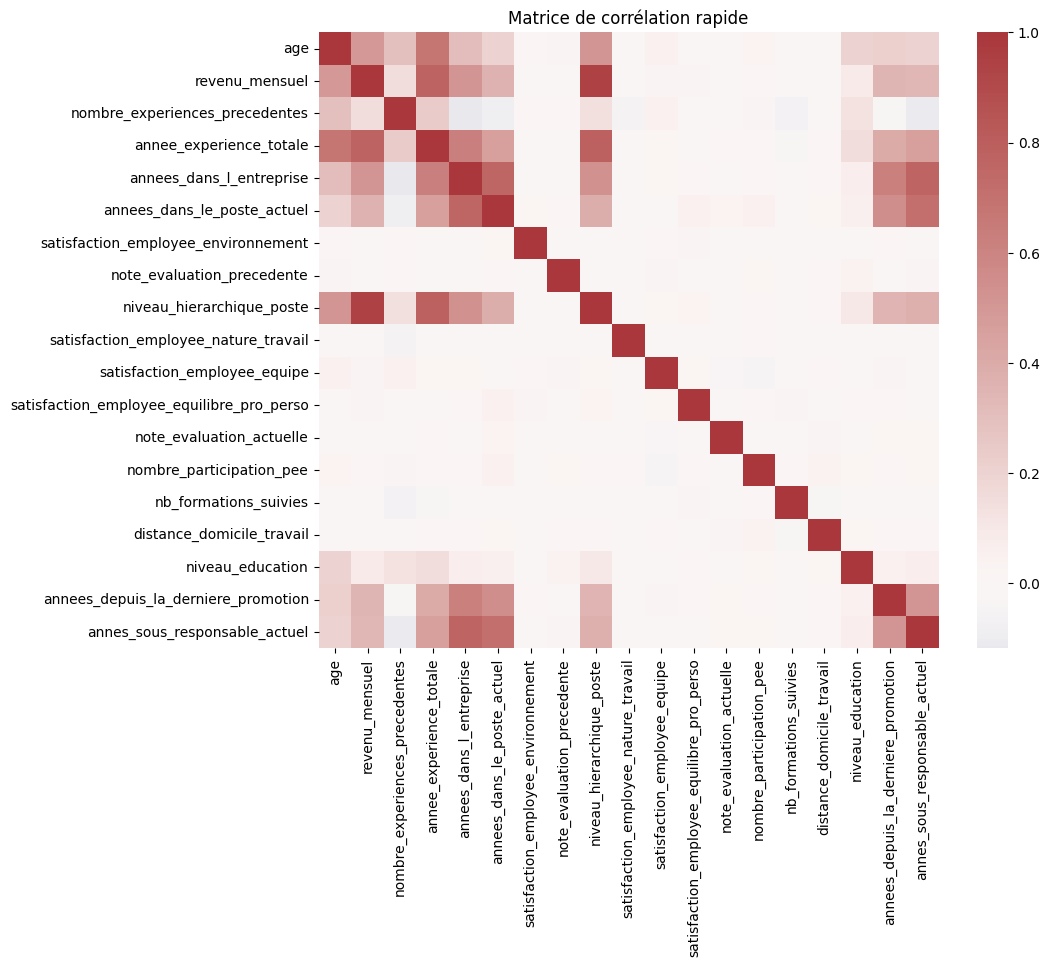

In [11]:
# Analyse de la cible
print(df_central['a_quitte_l_entreprise'].value_counts())
sns.countplot(x='a_quitte_l_entreprise', data=df_central)
plt.title("Répartition de la cible (attrition)")
plt.show()

# Distribution des features initiales selon la cible
plot_feature_distributions(df_central, features_init, target)

# Histogrammes et boxplots pour quelques features clés
features_num_viz = ['poste', 'departement', 'annes_sous_responsable_actuel', 'annees_dans_l_entreprise', 'annees_depuis_la_derniere_promotion', 'revenu_mensuel']
for col in features_num_viz:
    if df_central[col].dtype in ('int64', 'float64'):
        plt.figure(figsize=(7, 3))
        sns.histplot(df_central[col], bins=30)
        plt.title(f'Distribution de {col}')
        plt.show()
        plt.figure(figsize=(4, 3))
        sns.boxplot(x=df_central[col])
        plt.title(f'Boxplot de {col}')
        plt.show()
    else:
        print(f"Skipping non-numeric feature: {col}")


postes_par_dept = pd.crosstab(df_central['departement'], df_central['poste'])

plt.figure(figsize=(14,6))
sns.heatmap(postes_par_dept, cmap='Blues', annot=True, fmt='d')
plt.title("Répartition des postes par département")
plt.xlabel("Poste")
plt.ylabel("Département")
plt.tight_layout()
plt.show()

# Tableau croisé avec le % de départs ("Oui") par département et poste
departs_pct = (
    df_central[df_central['a_quitte_l_entreprise'].notnull()]
    .groupby(['departement', 'poste'])[target]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

# On prend la colonne "Oui" (pourcentage de départs)
departs_pct_oui = departs_pct['Oui']*100  # en %

# Pivot pour avoir un format matriciel
departs_pct_oui_mat = departs_pct_oui.unstack().fillna(0)

plt.figure(figsize=(14,6))
sns.heatmap(departs_pct_oui_mat, cmap='Reds', annot=True, fmt='.1f')
plt.title("% de départs par département et poste")
plt.xlabel("Poste")
plt.ylabel("Département")
plt.tight_layout()
plt.show()

# Tableau croisé : nombre de départs "Oui" par département et poste
departs_counts = (
    df_central[df_central[target] == 'Oui']  # filtre uniquement les départs
    .groupby(['departement', 'poste'])[target]
    .count()
)

# On donne le format "matriciel" pour le heatmap
departs_counts_mat = departs_counts.unstack().fillna(0)

plt.figure(figsize=(14,6))
sns.heatmap(departs_counts_mat, cmap='Oranges', annot=True, fmt='.0f')
plt.title("Nombre de départs par département et poste")
plt.xlabel("Poste")
plt.ylabel("Département")
plt.tight_layout()
plt.show()

# Corrélations rapides
plt.figure(figsize=(10, 8))
sns.heatmap(df_central.corr(numeric_only=True), cmap='vlag', center=0)
plt.title("Matrice de corrélation rapide")
plt.show()


## 6. Feature Engineering

La plupart des postes sont regroupés dans le département Consulting, le département Commercial contient 3 postes, et RH seulement 2. Le poste Senior Manager est le seul réparti sur plusieurs départements (les 3). Pour l'analyse, Nous allons créer une feature composite de ces deux features.

Nous allons également convertir l'augmentation de salaire en valeur numérique (au lieu de XX%), une feature boléenne de changement de responsable, quatres features de groupes de salaires (global en 4 groupes équivalents, ou selon les quartiles, au global, par poste, et par poste + ancienneté), Un indice d'évolution de salaire annuel depuis la dernière promotion, et un score de carrière (indice d'évolution de salaire/ancienneté totale, pondéré par le salaire).

In [12]:
# --- Feature engineering ---

# 1 - Feature composite Poste-Departement
df_central['poste_departement'] = df_central['poste'] + '_' + df_central['departement']

# 2 - Feature Changement de Responsable depuis l'année précédente
df_central['nouveau_responsable'] = np.where(df_central['annes_sous_responsable_actuel'] == 0, 'Oui', 'Non')

# 3 - Feature Conversion augementation_salaire_precedente en numérique (pour modéliser sur la valeur)
df_central['augmentation_salaire_precedente'] = (
    df_central['augementation_salaire_precedente']
    .str.replace('%', '', regex=False)
    .astype(int)
)

# 4 - Feature Indice d'évolution salariale (ratio annuel du pourcentage d'augmentation depuis la dernière promotion)
# Plus l'indice est élevé, meilleure est l'évolution.
df_central['indice_evolution_salaire'] = (
    (df_central['augmentation_salaire_precedente'] + 1e-6) / (df_central['annees_depuis_la_derniere_promotion'] + 1)
)

# 5 - Feature Score de carrière (indice évolution de salaire, divisé par années d'ancienneté, multiplié par log du salaire)
df_central['score_evolution_carriere'] = (
    df_central['indice_evolution_salaire'] *      # effet direct de l'évolution
    (1 / (df_central['annees_dans_l_entreprise'] + 1)) *  # pénalise la stagnation si très ancien
    np.log1p(df_central['revenu_mensuel'])        # pondère par le niveau de salaire (logarithme stabilise)
)

# 6 - Features Catégories de Salaires (découpage en 4 parties égales, ou en quantiles globaux, ou par poste, ou par poste + ancienneté)
df_central = create_salary_features(df_central, col_revenu='revenu_mensuel')

print("Features ajoutées")

Features ajoutées


## 7. Visualisations Exploratoires

In [13]:
df_central.describe(include='all')

,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,poste_departement,nouveau_responsable,augmentation_salaire_precedente,indice_evolution_salaire,score_evolution_carriere,salaire_cat,salaire_cat_eq,position_salaire_poste,position_salaire_poste_anc
count,1470.000000,1470,1470.000000,1470,1470,1470,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470,1470,1470,1470.000000,1470.000000,1470.000000,1470.000000,1470,1470,1470.000000,1470.000000,1470,1470,1470.000000,1470.000000,1470.000000,1470,1470,1470,1470
unique,NaN,2,NaN,3,3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,15,2,NaN,NaN,NaN,NaN,6,3,NaN,NaN,11,2,NaN,NaN,NaN,4,4,4,4
top,NaN,M,NaN,Marié(e),Consulting,Cadre Commercial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non,11 %,Non,NaN,NaN,NaN,NaN,Infra & Cloud,Occasionnel,NaN,NaN,Cadre Commercial_Commercial,Non,NaN,NaN,NaN,Bas,Très bas,Haut,Haut
freq,NaN,882,NaN,673,961,326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1054,210,1233,NaN,NaN,NaN,NaN,606,1043,NaN,NaN,326,1207,NaN,NaN,NaN,368,885,370,399
mean,36.923810,NaN,6502.931293,NaN,NaN,NaN,2.693197,11.279592,7.008163,4.229252,2.721769,2.729932,2.063946,2.728571,2.712245,2.761224,3.153741,NaN,NaN,NaN,0.793878,2.799320,9.192517,2.912925,NaN,NaN,2.187755,4.123129,NaN,NaN,15.209524,9.039095,20.503544,NaN,NaN,NaN,NaN
std,9.135373,NaN,4707.956783,NaN,NaN,NaN,2.498009,7.780782,6.126525,3.623137,1.093082,0.711561,1.106940,1.102846,1.081209,0.706476,0.360824,NaN,NaN,NaN,0.852077,1.289271,8.106864,1.024165,NaN,NaN,3.222430,3.568136,NaN,NaN,3.659938,6.045458,27.478742,NaN,NaN,NaN,NaN
min,18.000000,NaN,1009.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,NaN,NaN,NaN,0.000000,0.000000,1.000000,1.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,11.000000,0.733333,0.169046,NaN,NaN,NaN,NaN
25%,30.000000,NaN,2911.000000,NaN,NaN,NaN,1.000000,6.000000,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,3.000000,NaN,NaN,NaN,0.000000,2.000000,2.000000,2.000000,NaN,NaN,0.000000,2.000000,NaN,NaN,12.000000,4.000000,3.442307,NaN,NaN,NaN,NaN
50%,36.000000,NaN,4919.000000,NaN,NaN,NaN,2.000000,10.000000,5.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,NaN,NaN,NaN,1.000000,3.000000,7.000000,3.000000,NaN,NaN,1.000000,3.000000,NaN,NaN,14.000000,7.500000,11.628768,NaN,NaN,NaN,NaN
75%,43.000000,NaN,8379.000000,NaN,NaN,NaN,4.000000,15.000000,9.000000,7.000000,4.000000,3.000000,3.000000,4.000000,4.000000,3.000000,3.000000,NaN,NaN,NaN,1.000000,3.000000,14.000000,4.000000,NaN,NaN,3.000000,7.000000,NaN,NaN,18.000000,13.000001,21.907839,NaN,NaN,NaN,NaN


### Description
| Feature                             | Description                                          | Type/modalités ou stats clés                         |
|--------------------------------------|------------------------------------------------------|------------------------------------------------------|
| age                                 | Âge                                                  | Numérique (18–60, moy 36,9)                          |
| genre                               | Genre                                                | Catégoriel (M, F)                                    |
| revenu_mensuel                      | Salaire mensuel brut                                 | Numérique (1009–19999, moy 6502)                     |
| statut_marital                      | Statut marital                                       | Catégoriel (3 modalités : Marié(e), ...)             |
| departement                         | Département                                          | Catégoriel (3 modalités : Consulting, ...)           |
| poste                               | Poste                                                | Catégoriel (9 modalités)                             |
| nombre_experiences_precedentes       | Nb expériences préalables                            | Numérique (0–9, moy 2,69)                            |
| annee_experience_totale              | Expérience totale                                    | Numérique (0–40, moy 11,3)                           |
| annees_dans_l_entreprise             | Ancienneté entreprise                                | Numérique (0–40, moy 7)                              |
| annees_dans_le_poste_actuel          | Ancienneté poste actuel                              | Numérique (0–18, moy 4,2)                            |
| satisfaction_employee_environnement  | Satisfaction environnement                           | Ordinale (1–4, médiane 3)                            |
| note_evaluation_precedente           | Note précédente à l’évaluation                       | Ordinale (1–4, médiane 3)                            |
| niveau_hierarchique_poste            | Niveau hiérarchique                                  | Ordinale (1–5, médiane 2)                            |
| satisfaction_employee_nature_travail | Satisfaction nature du travail                       | Ordinale (1–4, médiane 3)                            |
| satisfaction_employee_equipe         | Satisfaction équipe                                  | Ordinale (1–4, médiane 3)                            |
| satisfaction_employee_equilibre_pro_perso | Satisfaction équilibre pro/perso               | Ordinale (1–4, médiane 3)                            |
| note_evaluation_actuelle             | Note d’évaluation actuelle                           | Ordinale (3–4, moy 3,15)                             |
| heure_supplementaires                | Heures supplémentaires                               | Binaire (Oui/Non)                                    |
| augementation_salaire_precedente     | Augment. salaire préc. (avant conversion)            | Catégoriel (15 modalités, ex: "11 %")                |
| a_quitte_l_entreprise                | Départ volontaire (cible)                            | Binaire (Oui/Non)                                    |
| nombre_participation_pee             | Nb participations PEE                                | Numérique (0–3, moy 0,79)                            |
| nb_formations_suivies                | Nb formations                                        | Numérique (0–6, moy 2,8)                             |
| distance_domicile_travail            | Distance domicile-travail                            | Numérique (1–29, moy 9,2)                            |
| niveau_education                     | Niveau d’éducation                                   | Ordinale (1–5, médiane 3)                            |
| domaine_etude                        | Domaine d’études                                     | Catégoriel (6 modalités)                             |
| frequence_deplacement                | Fréquence déplacement                                | Catégoriel (3 modalités)                             |
| annees_depuis_la_derniere_promotion  | Années depuis dernière promotion                     | Numérique (0–29, moy 2,19)                           |
| annes_sous_responsable_actuel        | Années sous responsable actuel                       | Numérique (0–17, moy 4,1)                            |
| poste_departement                    | Poste + département (feature créée)                  | Catégoriel (11 modalités)                            |
| nouveau_responsable                  | Changement de responsable (feature créée)            | Binaire (Oui/Non)                                    |
| augmentation_salaire_precedente      | Augment. salaire précédente, en % (feature créée)    | Numérique (11–25, moy 15,2)                          |
| indice_evolution_salaire             | Indice évolution salaire (feature créée)             | Numérique (0,7–25, moy 9,04)                         |
| score_evolution_carriere             | Score carrière (feature créée)                       | Numérique (0,17–215,6, moy 20,5)                     |
| salaire_cat                          | Catégorie salaire (feature créée)                    | Ordinale (Très bas, Bas, Moyen, Haut)                |
| salaire_cat_eq                       | Catégorie équi-largeur salaire (feature créée)       | Ordinale (Très bas, Bas, Moyen, Haut)                |
| position_salaire_poste               | Position salaire dans le poste (feature créée)       | Ordinale (Très bas, Bas, Moyen, Haut)                |
| position_salaire_poste_anc           | Position salaire poste+ancienneté (feature créée)    | Ordinale (Très bas, Bas, Moyen, Haut)                |
| score_carriere_cat                   | Score carrière catégorisé (feature créée)            | Catégoriel (Très bas, Bas, Moyen, Haut)              |
| indice_evol_sal                      | Indice évolution salarial catégorisé (feature créée) | Catégoriel (Très bas, Bas, Moyen, Haut)              |
| attrition_num                        | Départ (cible binaire encodée)                       | Numérique (0 = Non, 1 = Oui)                         |

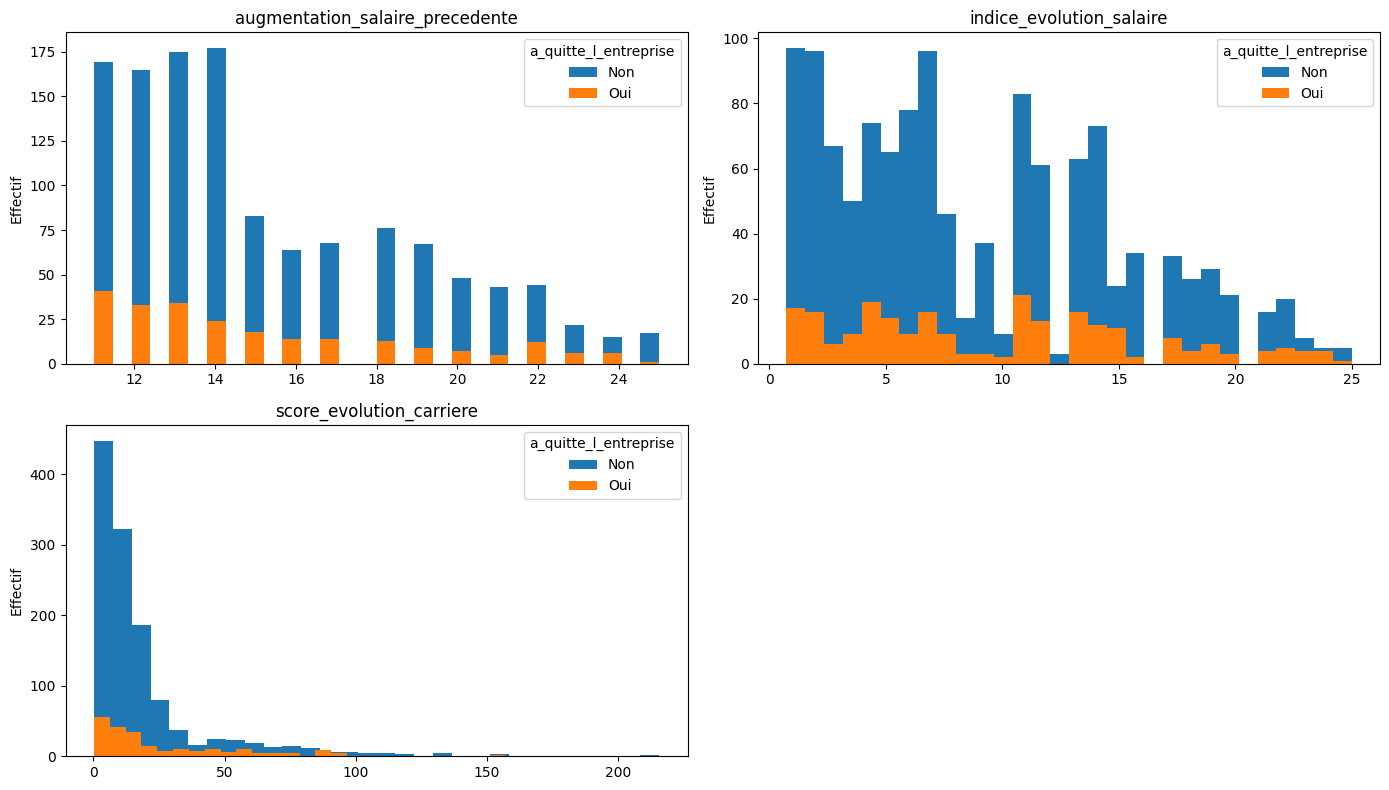

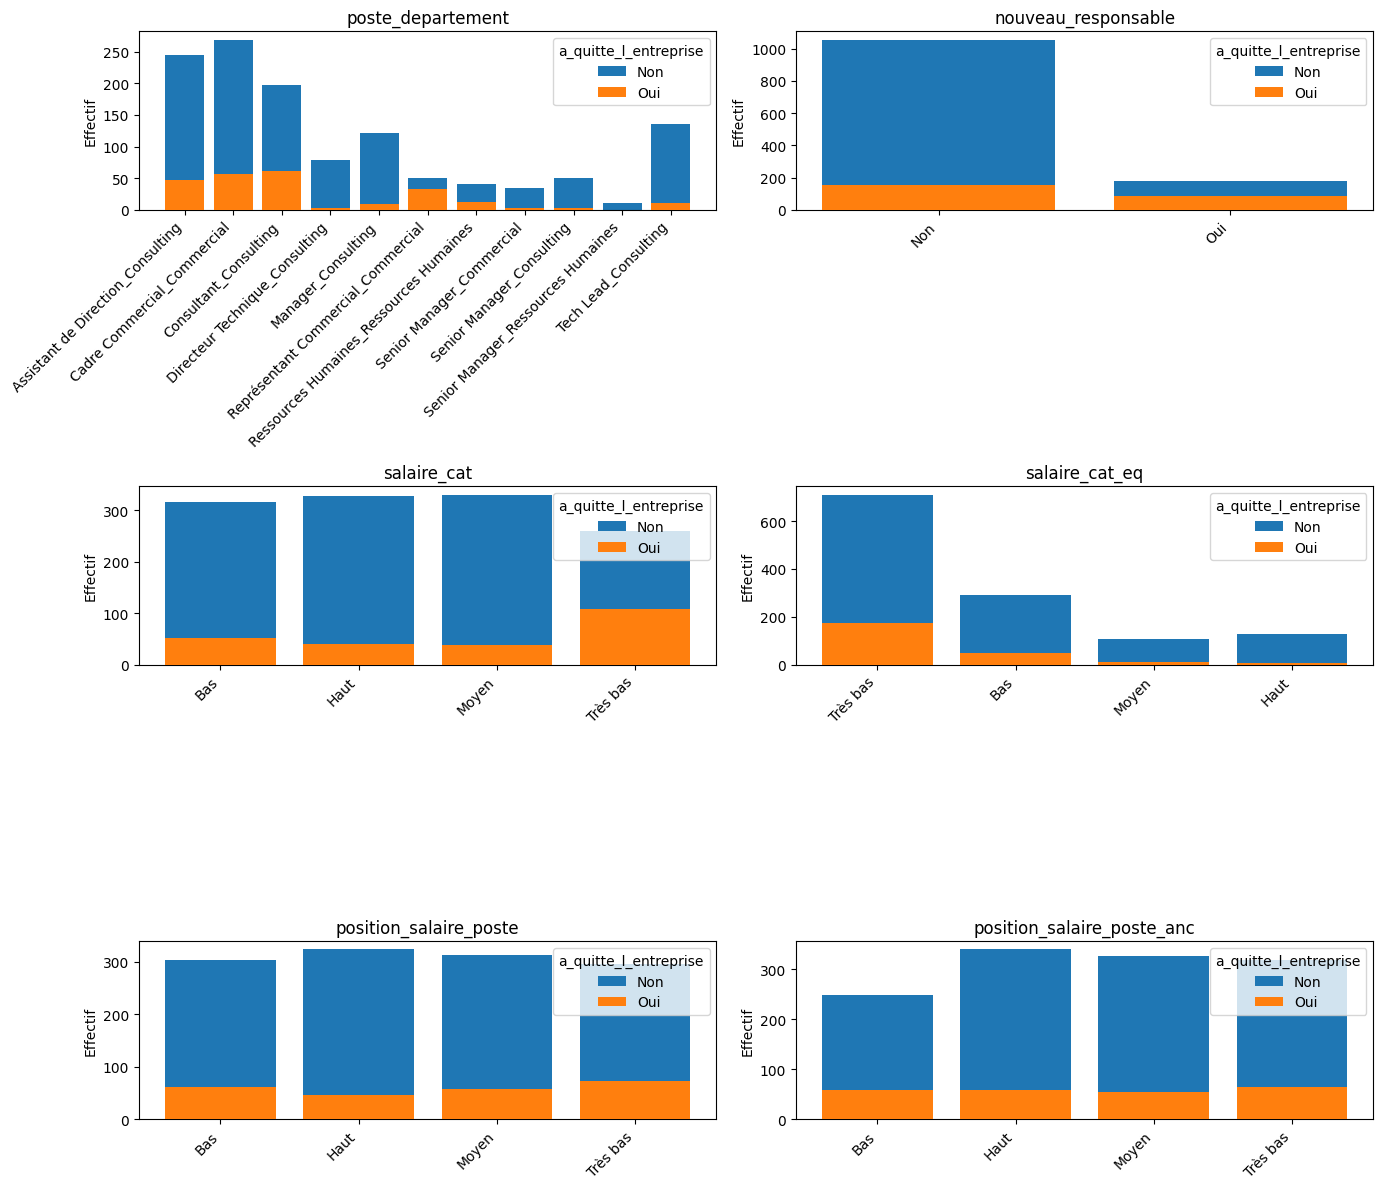

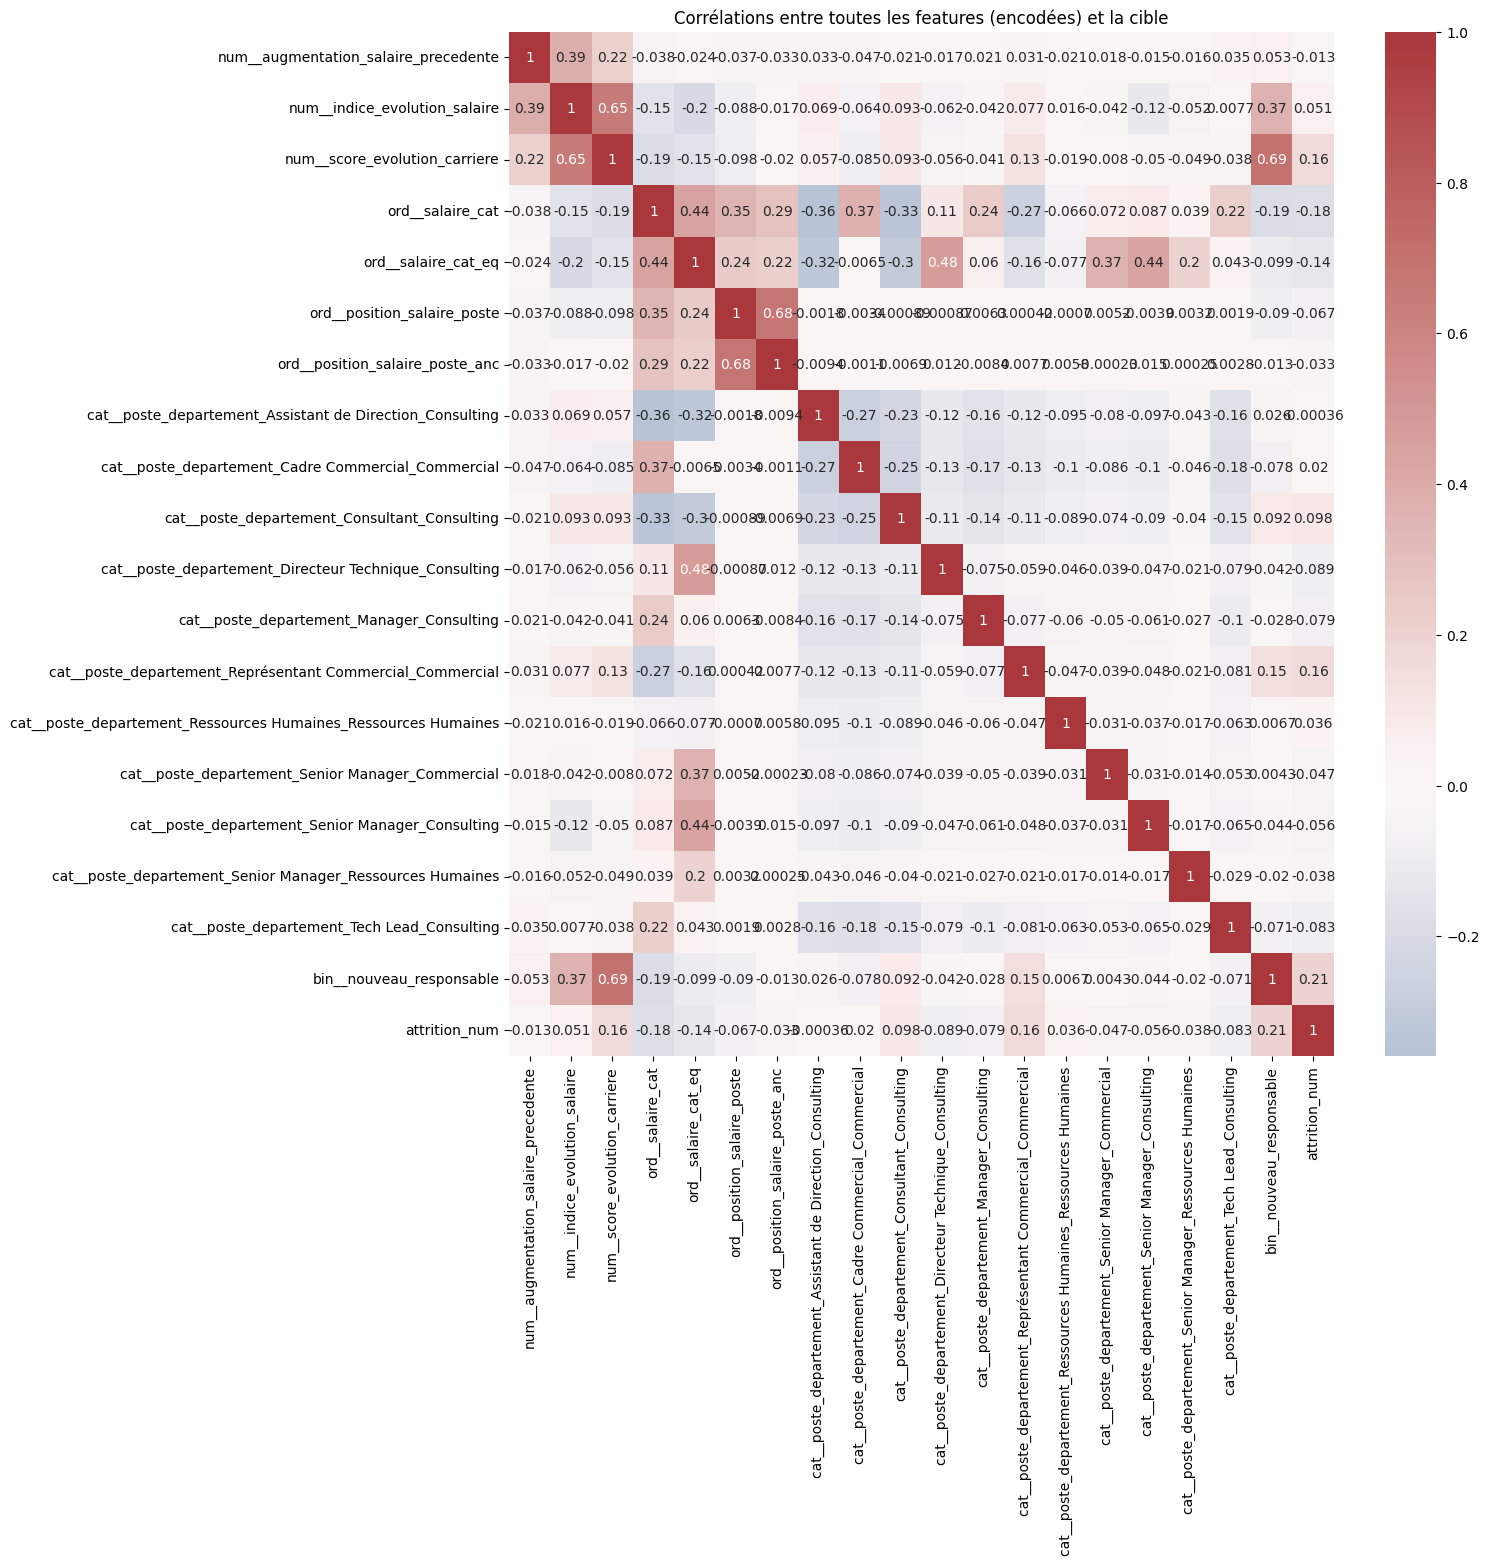

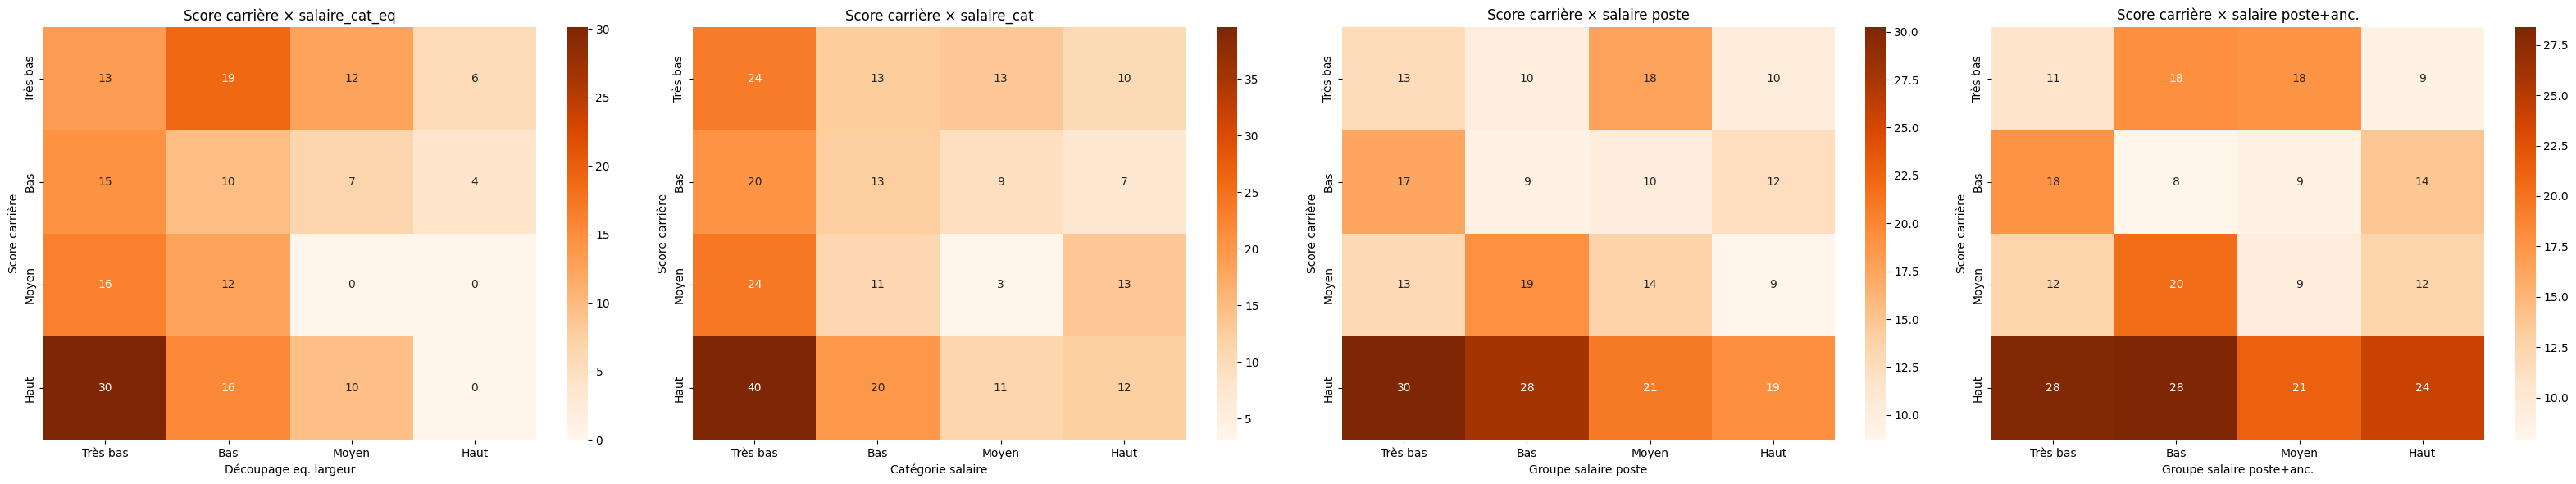

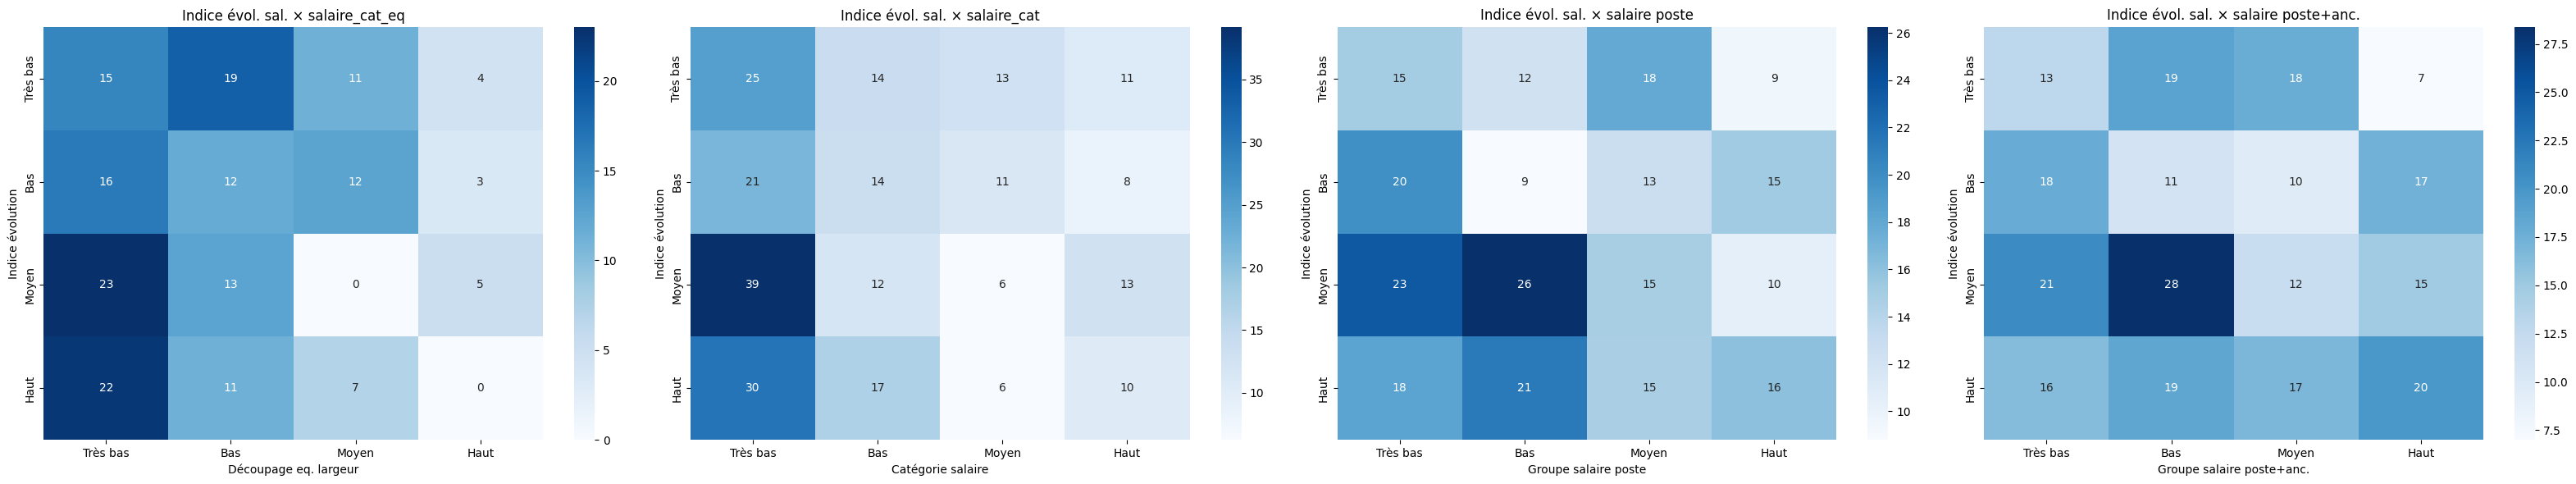

In [14]:
# Liste des nouvelles features créées
features_new = [
    'poste_departement',
    'nouveau_responsable',
    'augmentation_salaire_precedente',
    'indice_evolution_salaire',
    'score_evolution_carriere',
    'salaire_cat',
    'salaire_cat_eq',
    'position_salaire_poste',
    'position_salaire_poste_anc'
]

# Plots de distribution croisée avec la cible
plot_feature_distributions(df_central, features_new, target)

# Matrice de corrélation entre variables synthétiques et num

features_num = [
    'augmentation_salaire_precedente',
    'indice_evolution_salaire',
    'score_evolution_carriere'
]
features_ord = [
    'salaire_cat', 'salaire_cat_eq', 'position_salaire_poste', 'position_salaire_poste_anc'
]  # Si ordinales avec mapping approprié
features_cat = [
    'poste_departement'  # Ou d'autres variables fortement multi-modalités
]
features_bin = [
    'nouveau_responsable'
]

df_central['attrition_num'] = (df_central['a_quitte_l_entreprise'] == 'Oui').astype(int)
# Ordre dans ord_mappings selon l’ordre dans features_ord
ord_mappings = [
    ['Très bas', 'Bas', 'Moyen', 'Haut'],  # mapping pour les groupes salaires
    ['Très bas', 'Bas', 'Moyen', 'Haut'],  # idem si plusieurs
    ['Très bas', 'Bas', 'Moyen', 'Haut'],
    ['Très bas', 'Bas', 'Moyen', 'Haut']
]

preprocessor = build_preprocessor(features_num, features_ord, features_cat, features_bin, ord_mappings)
# Pour la matrice de corrélation sur l’encodé/scalé
X_corr = preprocessor.fit_transform(df_central[features_num + features_ord + features_cat + features_bin])
columns_corr = preprocessor.get_feature_names_out()
X_corr_df = pd.DataFrame(X_corr, columns=columns_corr)
# cible pour la corrélation
X_corr_df['attrition_num'] = df_central['attrition_num']
# Matrice de corrélation Pearson
corr_matrix = X_corr_df.corr(method='pearson')

plt.figure(figsize=(min(18, 0.7*len(columns_corr)), min(18, 0.7*len(columns_corr))))
sns.heatmap(corr_matrix, annot=True, cmap='vlag', center=0)
plt.title("Corrélations entre toutes les features (encodées) et la cible")
plt.show()


# Création des features catégorielles (quantiles)
ordre_labels = ["Très bas", "Bas", "Moyen", "Haut"]
df_central['score_carriere_cat'] = pd.qcut(df_central['score_evolution_carriere'], q=4, labels=ordre_labels)
df_central['indice_evol_cat'] = pd.qcut(df_central['indice_evolution_salaire'], q=4, labels=ordre_labels)

# Visualisation heatmaps croisant les catégories synthétiques et les groupes salaires via la fonction dédiée
plot_heatmaps_cat(
    df_central,
    row_cat="score_carriere_cat",
    col_cats=["salaire_cat_eq", "salaire_cat", "position_salaire_poste", "position_salaire_poste_anc"],
    target='a_quitte_l_entreprise',
    ordre_labels=ordre_labels,
    cmap="Oranges",
    titles=[
        "Score carrière × salaire_cat_eq",
        "Score carrière × salaire_cat",
        "Score carrière × salaire poste",
        "Score carrière × salaire poste+anc."
    ],
    xlabels=[
        "Découpage eq. largeur",
        "Catégorie salaire",
        "Groupe salaire poste",
        "Groupe salaire poste+anc."
    ],
    ylabel="Score carrière"
)

plot_heatmaps_cat(
    df_central,
    row_cat="indice_evol_cat",
    col_cats=["salaire_cat_eq", "salaire_cat", "position_salaire_poste", "position_salaire_poste_anc"],
    target='a_quitte_l_entreprise',
    ordre_labels=ordre_labels,
    cmap="Blues",
    titles=[
        "Indice évol. sal. × salaire_cat_eq",
        "Indice évol. sal. × salaire_cat",
        "Indice évol. sal. × salaire poste",
        "Indice évol. sal. × salaire poste+anc."
    ],
    xlabels=[
        "Découpage eq. largeur",
        "Catégorie salaire",
        "Groupe salaire poste",
        "Groupe salaire poste+anc."
    ],
    ylabel="Indice évolution"
)

#### Vérification de l'affichage de la heatmap

In [15]:
categories_features = ['salaire_cat_eq', 'salaire_cat', 'position_salaire_poste', 'position_salaire_poste_anc']
score_vars = ['score_carriere_cat', 'indice_evol_cat']

for score in score_vars:
    for cat_feat in categories_features:
        print(f"\nPourcentage d'attrition pour {score}='Haut' et chaque modalité de {cat_feat} :")
        # Calc effectif total "Haut" pour chaque catégorie
        total_par_cat = df_central[
            (df_central[score] == 'Haut')
            ].groupby(cat_feat, observed=True).size()

        for cat in ordre_labels:
            eff_oui = df_central[
                (df_central[score] == 'Haut') &
                (df_central[cat_feat] == cat) &
                (df_central['a_quitte_l_entreprise'] == 'Oui')
            ].shape[0]
            eff_total = total_par_cat.get(cat, 0)
            pct = 100 * eff_oui / eff_total if eff_total > 0 else 0
            print(f"  - {cat_feat} = {cat} : {pct:.1f}% ({eff_oui}/{eff_total})")



Pourcentage d'attrition pour score_carriere_cat='Haut' et chaque modalité de salaire_cat_eq :
  - salaire_cat_eq = Très bas : 30.1% (82/272)
  - salaire_cat_eq = Bas : 15.5% (9/58)
  - salaire_cat_eq = Moyen : 9.5% (2/21)
  - salaire_cat_eq = Haut : 0.0% (0/17)

Pourcentage d'attrition pour score_carriere_cat='Haut' et chaque modalité de salaire_cat :
  - salaire_cat = Très bas : 39.6% (59/149)
  - salaire_cat = Bas : 20.0% (20/100)
  - salaire_cat = Moyen : 11.1% (6/54)
  - salaire_cat = Haut : 12.3% (8/65)

Pourcentage d'attrition pour score_carriere_cat='Haut' et chaque modalité de position_salaire_poste :
  - position_salaire_poste = Très bas : 30.3% (36/119)
  - position_salaire_poste = Bas : 27.7% (26/94)
  - position_salaire_poste = Moyen : 21.0% (13/62)
  - position_salaire_poste = Haut : 19.4% (18/93)

Pourcentage d'attrition pour score_carriere_cat='Haut' et chaque modalité de position_salaire_poste_anc :
  - position_salaire_poste_anc = Très bas : 28.1% (25/89)
  - position

Après analyse des heatmaps croisées et de la matrice de corrélation, il apparaît que chaque groupe de features liées au salaire et à la progression (catégories, scores d’évolution, variables contextuelles) offre une information complémentaire sans réelle redondance.
Je recommande donc de conserver l’ensemble de ces variables pour la modélisation : cela garantit un modèle plus robuste, capable de capturer toutes les dimensions du risque d’attrition, quitte à affiner la sélection selon l’importance des features après entraînement.

### Profils à risque

Affichage des principaux postes de départ, et des départs en fonction des notes agrégées et des catégories de salaires, avec heures supp et nouveau responsable.

In [21]:
# Facultatif : Limiter aux 5 + grands, rassembler les autres
main_labels = postes_counts[:5].index.tolist() + ['Autres']
main_sizes = postes_counts[:5].tolist() + [postes_counts[5:].sum()]

plt.figure(figsize=(8,8))
plt.pie(
    main_sizes,
    labels=main_labels,
    autopct='%1.0f%%',
    startangle=90,
    pctdistance=0.8,
    labeldistance=1.15,
    explode=[0.03]*len(main_labels),   # Franchement optionnel : décolle les parts
    wedgeprops={"linewidth": 1, "edgecolor": "white"},
    colors=plt.cm.tab20.colors
)
plt.title("Répartition des postes parmi les départs")
plt.tight_layout()
plt.show()


NameError: name 'postes_counts' is not defined

Pivot :
satisfaction_cat  Très faible     Faible      Bonne  Excellente
salaire_cat                                                    
Haut                75.000000  33.333333   0.000000    0.000000
Moyen               75.000000   0.000000  25.000000    0.000000
Bas                 50.000000   0.000000  25.000000   50.000000
Très bas            92.307692  83.333333  83.333333   63.636364


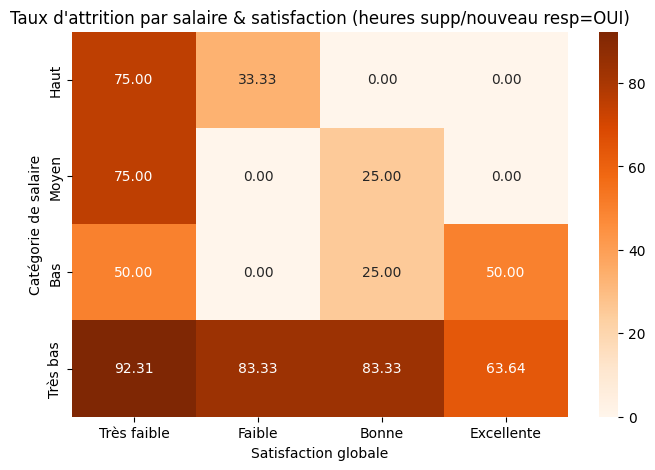

In [17]:
# 1. Agrégation satisfaction
satisfaction_vars = [
    'satisfaction_employee_environnement',
    'satisfaction_employee_nature_travail',
    'satisfaction_employee_equipe',
    'satisfaction_employee_equilibre_pro_perso'
]
df_central['satisfaction_globale'] = df_central[satisfaction_vars].mean(axis=1)

# 2. Catégorisation satisfaction (quartiles - modifiable)
df_central['satisfaction_cat'] = pd.qcut(df_central['satisfaction_globale'], 4, labels=['Très faible', 'Faible', 'Bonne', 'Excellente'])

cat_order = ['Haut', 'Moyen', 'Bas', 'Très bas']
df_central['salaire_cat'] = pd.Categorical(df_central['salaire_cat'], categories=cat_order, ordered=True)

# 3. Sous-ensemble filtre RH
subset = df_central[
    (df_central['heure_supplementaires'] == 'Oui')
    & (df_central['nouveau_responsable'] == 'Oui')
]

# 4. Création tableau croisé
pivot = subset.pivot_table(
    index='salaire_cat',
    columns='satisfaction_cat',
    values='a_quitte_l_entreprise',
    observed=False,
    aggfunc=lambda x: (x == 'Oui').mean()
).fillna(0)  # corrige les NaN pour visuel

pivot = pivot * 100
print("Pivot :")
print(pivot)

# 5. Affichage heatmap (seulement si non vide)
if not pivot.empty:
    plt.figure(figsize=(8,5))
    sns.heatmap(pivot, cmap='Oranges', annot=True, fmt=".2f")
    plt.title("Taux d'attrition par salaire & satisfaction (heures supp/nouveau resp=OUI)")
    plt.xlabel("Satisfaction globale")
    plt.ylabel("Catégorie de salaire")
    plt.show()
else:
    print("Aucune donnée dans ce segment, élargis tes catégories ou retire un filtre.")


## 8. Préparation des jeux d'apprentissage

### Features list

In [18]:
features_num = [ #(23)
    'age',
    'revenu_mensuel',
    'nombre_experiences_precedentes', 
    'annee_experience_totale',
    'annees_dans_l_entreprise',
    'annees_dans_le_poste_actuel',
    'satisfaction_employee_environnement',
    'note_evaluation_actuelle',
    'note_evaluation_precedente',
    'niveau_hierarchique_poste',
    'satisfaction_employee_nature_travail',
    'satisfaction_employee_equipe',
    'satisfaction_employee_equilibre_pro_perso',
    'nombre_participation_pee',
    'nb_formations_suivies',
    'distance_domicile_travail',
    'niveau_education',
    'annees_depuis_la_derniere_promotion',
    'annes_sous_responsable_actuel',
    'augmentation_salaire_precedente', 
    'score_evolution_carriere',
    'indice_evolution_salaire'
]

features_ord = [ #(6)
    'frequence_deplacement',
    'salaire_cat',
    'salaire_cat_eq', 
    'position_salaire_poste',
    'position_salaire_poste_anc', 
    'score_carriere_cat',
    'indice_evol_cat'
]

ord_mappings = [
    ['Aucun', 'Occasionnel', 'Frequent'],  # frequence_deplacement
    ['Très bas', 'Bas', 'Moyen', 'Haut'],  # salaire_cat
    ['Très bas', 'Bas', 'Moyen', 'Haut'],  # salaire_cat_eq
    ['Très bas', 'Bas', 'Moyen', 'Haut'],  # position_salaire_poste
    ['Très bas', 'Bas', 'Moyen', 'Haut'],  # position_salaire_poste_anc
    ['Très bas', 'Bas', 'Moyen', 'Haut'],  # score_carriere_cat
    ['Très bas', 'Bas', 'Moyen', 'Haut']   # indice_evol_cat
]

features_cat = [ #(3)
    'statut_marital',
    'domaine_etude',
    'poste_departement'
]

features_bin = [ #(3)
    'genre',
    'heure_supplementaires',
    'nouveau_responsable'
]

# Target encodée
target = 'attrition_num'

all_features = features_num + features_ord + features_cat + features_bin + [target]
data_subset = df_central[all_features].copy()

### Split des données

In [19]:
# Target
y = (df_central[target])

# Séparation des features explicatives et de la target
X = data_subset.drop(columns=[target])

# Split stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,           # 20% pour le test, 80 pour le train
    stratify=y,              # stratification sur la cible
    random_state=42          
)

### Matrice de Corrélation

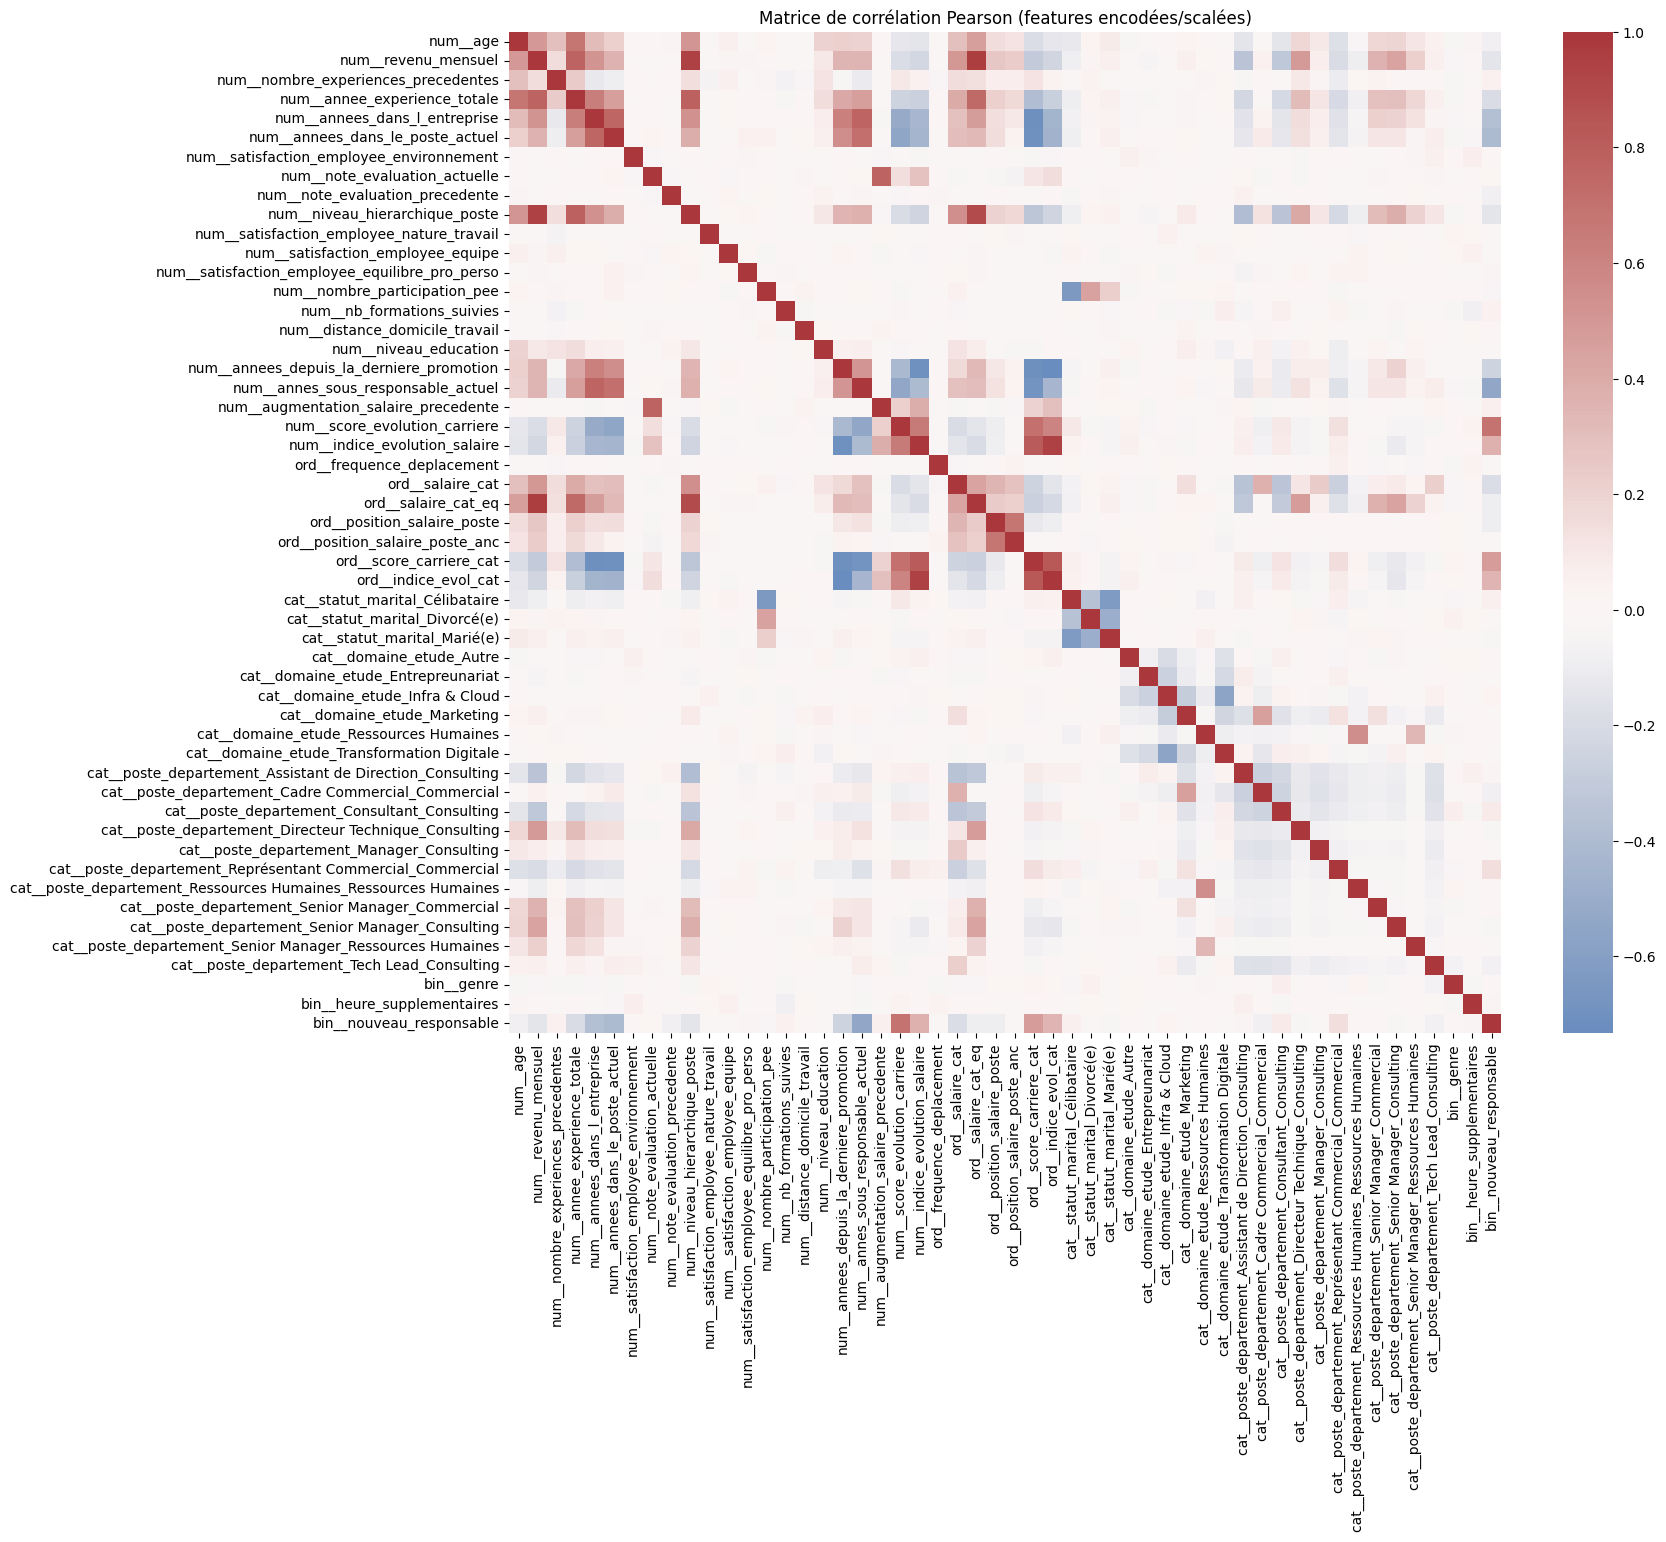

In [22]:
preprocessor = build_preprocessor(
    features_num, features_ord, features_cat, features_bin, ord_mappings
)

X_corr = preprocessor.fit_transform(data_subset.drop(columns=[target]))

columns_corr = preprocessor.get_feature_names_out()

X_corr_df = pd.DataFrame(X_corr, columns=columns_corr)

corr_matrix = X_corr_df.corr(method='pearson')

plt.figure(figsize=(16, 13))
sns.heatmap(corr_matrix, cmap='vlag', center=0)
plt.title("Matrice de corrélation Pearson (features encodées/scalées)")
plt.show()


## 9. Construction des Pipelines de modèles de Base

In [23]:
# 1. Définition des modèles de base
models = {
    'dummy': DummyClassifier(strategy='most_frequent'),
    'logreg': LogisticRegression(max_iter=1000),
    'rf': RandomForestClassifier(n_estimators=100, random_state=42),
    'xgb': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'lgbm': LGBMClassifier(random_state=42, verbose=-1)
}

# 2. pipeline
pipelines = build_model_pipelines(models, preprocessor)  # Appel de la fonction

# 3. Scoring multi-métriques
scoring = get_scoring_dict(pos_label=1)

# 4. Cross-validation et tableau de scores
cv_results_bal_df = crossval_score_models(pipelines, X_train, y_train, cv=5, scoring=scoring)
display(cv_results_bal_df.sort_values('F2', ascending=False))

,Model,Accuracy,Precision,Recall,F1,F2,PR-AUC
1,logreg,88.9,75.2,46.8,57.6,50.6,67.7
3,xgb,86.8,67.4,36.3,46.9,39.9,57.2
4,lgbm,87.0,69.0,35.8,47.0,39.5,58.5
2,rf,86.2,78.3,20.0,31.6,23.4,52.0
0,dummy,83.8,0.0,0.0,0.0,0.0,16.2


## 10. Comparaisons avec modèles "balanced" & Choix des meilleurs candidats

In [24]:
# 1. Définition des modèles "balanced"
models = {
    'logreg_bal': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'rf_bal': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'xgb_bal' : XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=42),
    'lgbm_bal' : LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1)
}

# 2. pipeline
pipelines = build_model_pipelines(models, preprocessor)  # Appel de la fonction

# 3. Scoring multi-métriques
scoring = get_scoring_dict(pos_label=1)

# 4. Cross-validation et tableau de scores
cv_results_bal_df = crossval_score_models(pipelines, X_train, y_train, cv=5, scoring=scoring)
display(cv_results_bal_df.sort_values('F2', ascending=False))

,Model,Accuracy,Precision,Recall,F1,F2,PR-AUC
0,logreg_bal,77.3,39.7,74.7,51.6,63.2,63.4
3,lgbm_bal,86.9,63.4,46.3,53.0,48.7,59.3
2,xgb_bal,86.4,61.3,44.2,51.2,46.7,57.7
1,rf_bal,85.8,84.4,14.7,24.5,17.5,51.9


In [25]:
models_balanced = {
    'logreg_bal': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'rf_bal': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'xgb_bal': XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=42),
    'lgbm_bal': LGBMClassifier(scale_pos_weight=scale_pos_weight, random_state=42, verbose=-1)
}

models_regular = {
    'logreg': LogisticRegression(max_iter=1000),
    'rf': RandomForestClassifier(n_estimators=100, random_state=42),
    'xgb': XGBClassifier(eval_metric='logloss', random_state=42),
    'lgbm': LGBMClassifier(random_state=42, verbose=-1)
}

pipelines_all = {}

# --- BALANCED only ---
for name, model in models_balanced.items():
    pipelines_all[f"{name}"] = ImbPipeline([('preprocessor', preprocessor), ('clf', model)])

# --- SMOTE only ---
for name, model in models_regular.items():
    pipelines_all[f"{name}_smote"] = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('clf', model)])

# --- BALANCED + SMOTE ---
for name, model in models_balanced.items():
    pipelines_all[f"{name}_smote"] = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('clf', model)])

# --- Cross-validation ---
scoring = get_scoring_dict(pos_label=1)
cv_results_df = crossval_score_models(pipelines_all, X_train, y_train, cv=5, scoring=scoring)
display(cv_results_df.sort_values('Model', ascending=False))


,Model,Accuracy,Precision,Recall,F1,F2,PR-AUC
6,xgb_smote,87.4,70.9,38.4,49.6,42.2,59.4
10,xgb_bal_smote,86.0,57.8,48.4,52.5,49.9,59.4
2,xgb_bal,86.4,61.3,44.2,51.2,46.7,57.7
5,rf_smote,87.5,78.4,31.6,44.8,35.8,57.3
9,rf_bal_smote,87.5,78.4,31.6,44.8,35.8,57.3
1,rf_bal,85.8,84.4,14.7,24.5,17.5,51.9
4,logreg_smote,79.3,42.0,73.2,53.2,63.5,63.3
8,logreg_bal_smote,79.3,42.0,73.2,53.2,63.5,63.3
0,logreg_bal,77.3,39.7,74.7,51.6,63.2,63.4
7,lgbm_smote,87.4,70.9,37.4,48.8,41.2,60.7


## 11. Optimisation des Hyperparamètres

In [26]:
# -- Définition scorer F2
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1, zero_division=0)

# -- Modèles à gridsercher (avec et sans SMOTE)
models = {
    'logreg_bal': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'rf_bal': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'xgb_bal': XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=42),
    'lgbm_bal': LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1)
}

param_grids = {
    'logreg_bal': {
        'clf__C': [0.05, 0.1],
        'clf__penalty': ['l2', 'l1'],
        'clf__solver': ['liblinear', 'saga']
    },
    'rf_bal': {
        'clf__n_estimators': [100, 198],
        'clf__max_depth': [5, 11]
    },
    'xgb_bal': {
        'clf__learning_rate': [0.31, 0.3],
        'clf__n_estimators': [151, 152],
        'clf__max_depth': [1, 2]
    },
    'lgbm_bal': {
        'clf__learning_rate': [0.095, 0.097],
        'clf__n_estimators': [145, 150],
        'clf__max_depth': [1, 2],
        'clf__num_leaves': [2, 4]
    }
}

variants = [
    ('', None),  # sans SMOTE
    ('_smote', SMOTE(random_state=42))
]

best_models = {}
best_params = {}

for model_name, model in models.items():
    for suffix, smote in variants:
        steps = [('preprocessor', preprocessor)]
        if smote is not None:
            steps.append(('smote', smote))
        steps.append(('clf', model))
        pipe = ImbPipeline(steps)
        param_grid = param_grids[model_name]
        gs = GridSearchCV(
            pipe,
            param_grid,
            scoring=f2_scorer,
            cv=5,
            refit=True,
            n_jobs=-1
        )
        gs.fit(X_train, y_train)  # Se fait uniquement sur le train !
        key = f"{model_name}{suffix}"
        best_models[key] = gs.best_estimator_
        best_params[key] = gs.best_params_
        print(f"Meilleurs hyperparamètres {key} : {gs.best_params_}")

# -- Cross-validation et reporting sur le TRAIN seulement --
results_cv = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for key, model in best_models.items():
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        # Seuil optimal CV sur fold train
        best_t_cv = find_optimal_threshold_cv(model, X_fold_train, y_fold_train, beta=2, n_splits=5)
        model.fit(X_fold_train, y_fold_train)
        y_proba_val = model.predict_proba(X_fold_val)[:, 1]
        y_pred_val = (y_proba_val >= best_t_cv).astype(int)
        results_cv.append(metrics_table(y_fold_val, y_pred_val, y_proba_val, f"{key}_fold{fold_idx+1}", best_t_cv))

# On extrait les colonnes numériques à moyenner
numeric_cols = ['Seuil', 'Accuracy (%)', 'Précision (%)', 'Rappel (%)', 'F1 (%)', 'F2 (%)', 'PR-AUC (%)']

df_metrics_cv = pd.DataFrame(results_cv)  # Agrège tous tes résultats folds/modèles

# On regroupe par le nom de base du modèle (sans foldX)
df_metrics_cv['Base'] = df_metrics_cv['Modèle'].str.replace('_fold[0-9]+', '', regex=True)
for col in numeric_cols:
    df_metrics_cv[col] = pd.to_numeric(df_metrics_cv[col], errors='coerce')

# On regroupe par le nom de base du modèle (sans foldX)
df_metrics_cv['Base'] = df_metrics_cv['Modèle'].str.replace('_fold[0-9]+', '', regex=True)
df_summary = df_metrics_cv.groupby('Base')[numeric_cols].mean().round(2)
display(df_summary)


Meilleurs hyperparamètres logreg_bal : {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Meilleurs hyperparamètres logreg_bal_smote : {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Meilleurs hyperparamètres rf_bal : {'clf__max_depth': 5, 'clf__n_estimators': 198}
Meilleurs hyperparamètres rf_bal_smote : {'clf__max_depth': 5, 'clf__n_estimators': 100}
Meilleurs hyperparamètres xgb_bal : {'clf__learning_rate': 0.3, 'clf__max_depth': 1, 'clf__n_estimators': 151}
Meilleurs hyperparamètres xgb_bal_smote : {'clf__learning_rate': 0.3, 'clf__max_depth': 1, 'clf__n_estimators': 152}
Meilleurs hyperparamètres lgbm_bal : {'clf__learning_rate': 0.095, 'clf__max_depth': 2, 'clf__n_estimators': 145, 'clf__num_leaves': 4}
Meilleurs hyperparamètres lgbm_bal_smote : {'clf__learning_rate': 0.097, 'clf__max_depth': 1, 'clf__n_estimators': 145, 'clf__num_leaves': 2}


,Seuil,Accuracy (%),Précision (%),Rappel (%),F1 (%),F2 (%),PR-AUC (%)
Base,,,,,,,
lgbm_bal,0.38,72.46,33.52,71.60,45.28,57.88,60.24
lgbm_bal_smote,0.34,73.80,35.90,71.60,46.92,58.64,61.64
logreg_bal,0.50,77.04,39.76,75.26,51.68,63.44,65.54
logreg_bal_smote,0.46,75.66,38.32,78.42,51.20,64.50,64.40
rf_bal,0.34,65.74,29.94,78.44,42.98,58.66,52.36
rf_bal_smote,0.33,71.00,34.44,74.18,45.82,58.72,56.42
xgb_bal,0.47,77.62,40.90,72.12,51.42,61.72,64.14
xgb_bal_smote,0.54,75.16,37.54,78.94,50.76,64.50,63.62


| Nom de la métrique      | Définition concise                                                        | Quand l'utiliser ?                                                  |
|-------------------------|---------------------------------------------------------------------------|---------------------------------------------------------------------|
| Accuracy (Exactitude)   | Proportion de bonnes prédictions sur l'ensemble des cas                   | Bonne en dataset équilibré, à interpréter sinon                     |
| Precision (Précision)   | %age de vrais positifs sur toutes les prédictions positives               | Important si faux positifs coûteux (alertes inutiles)               |
| Recall (Rappel)         | %age de cas positifs correctement prédits                                 | Important si faux négatifs coûteux (cas manqués, ex : départs non détectés) |
| F1-score                | Moyenne harmonique précision/recall                                       | Mesure globale, surtout si classes déséquilibrées                   |
| **F2-score**            | Moyenne harmonique, **donne plus de poids au rappel qu'à la précision**   | Quand il faut maximiser la détection des cas positifs, RH, fraude,… |
| Matrice de confusion    | Tableau croisant vrais/faux positifs/négatifs                             | Pour analyse détaillée du type d'erreurs du modèle                  |
| PR-AUC                  | Aire sous la courbe précision-recall                                      | Modèles probabilistes, très pertinent en data déséquilibrée         |


**Pourquoi le F2-score ?**  
Je privilégie le F2-score pour maximiser le rappel : il permet de détecter le plus de départs possibles, quitte à générer davantage de fausses alertes.

**Pourquoi ces modèles ?**  
- **logreg_bal_smote** : champion métier grâce au meilleur F2-score (détection RH optimale)
- **lgbm_bal** : inclus pour répondre au prérequis pédagogique sur les modèles non-linéaires

**Choix final :**  
Le reporting métier repose sur logreg_bal_smote, avec lgbm_bal en complément pour analyse technique et benchmark.


,Seuil,Rappel (%),Précision (%),F2 (%),PR-AUC (%)
Base,,,,,
lgbm_bal,0.38,71.60,33.52,57.88,60.24
lgbm_bal_smote,0.34,71.60,35.90,58.64,61.64
logreg_bal,0.50,75.26,39.76,63.44,65.54
logreg_bal_smote,0.46,78.42,38.32,64.50,64.40
rf_bal,0.34,78.44,29.94,58.66,52.36
rf_bal_smote,0.33,74.18,34.44,58.72,56.42
xgb_bal,0.47,72.12,40.90,61.72,64.14
xgb_bal_smote,0.54,78.94,37.54,64.50,63.62


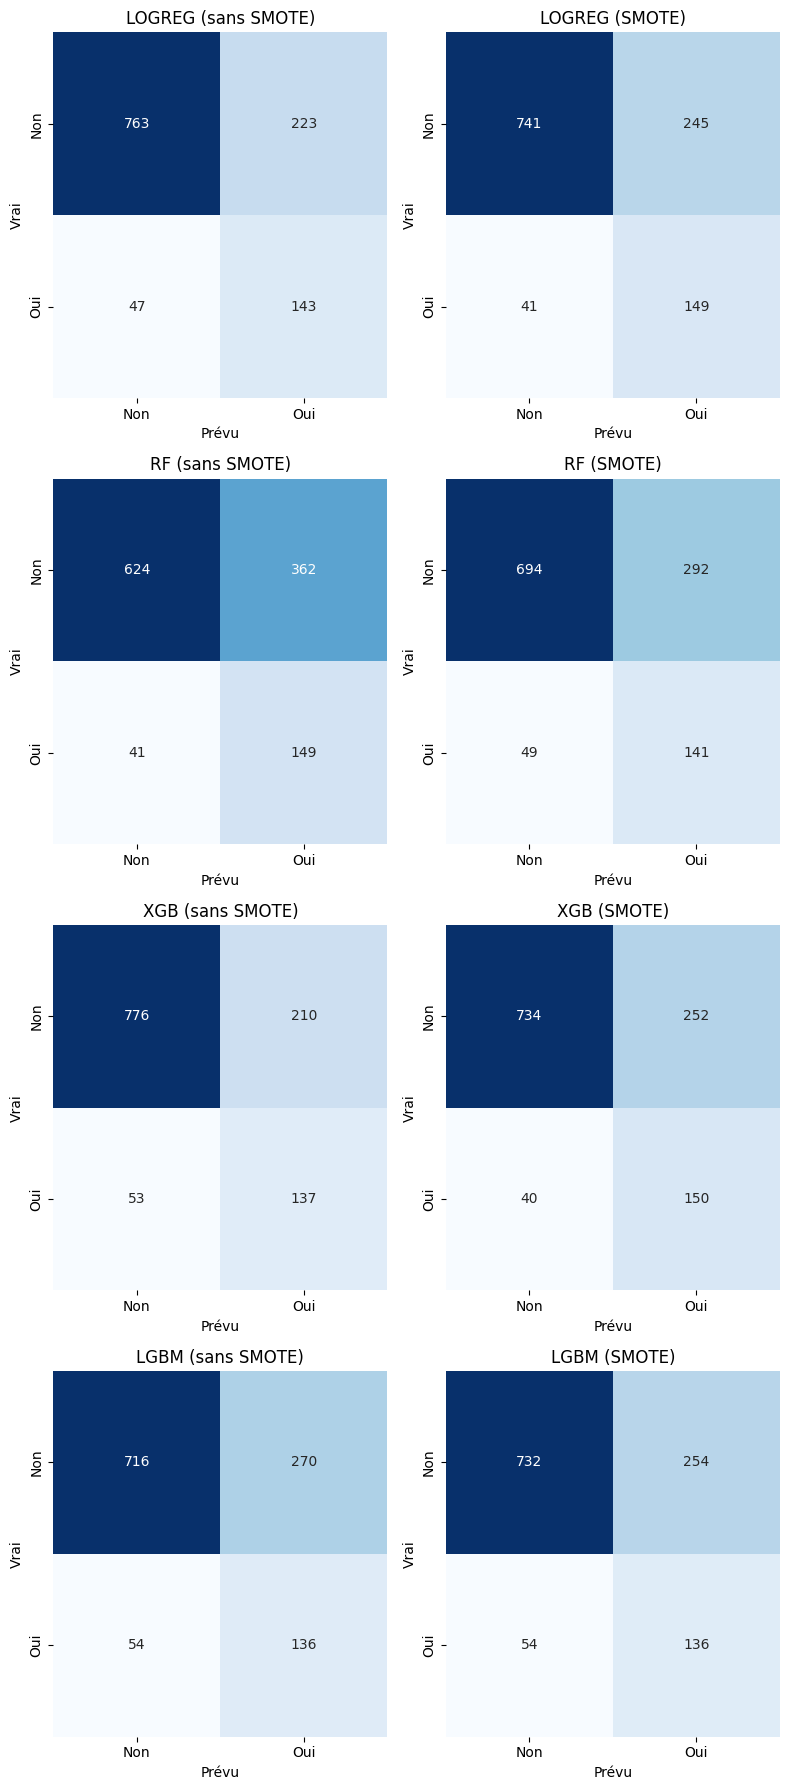

In [27]:
# --------- Fonction seuil optimal CV déjà existante -----------
def find_optimal_threshold_cv(model, X_train, y_train, beta=2, n_splits=5):
    thresholds = np.linspace(0, 1, 101)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_thresholds = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_fold_train, y_fold_train)
        y_proba_val = model.predict_proba(X_fold_val)[:, 1]
        f2_scores = [fbeta_score(y_fold_val, (y_proba_val >= t), beta=beta) for t in thresholds]
        best_idx = np.argmax(f2_scores)
        best_thresholds.append(thresholds[best_idx])

    return np.mean(best_thresholds)  # seuil optimal moyen CV

# --------- Calcul et reporting pour tous les modèles optimisés ----------
results = []
all_conf_matrices = {}

for name, model in best_models.items():
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    conf_matrices = []
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        best_t_cv = find_optimal_threshold_cv(model, X_fold_train, y_fold_train, beta=2, n_splits=5)
        model.fit(X_fold_train, y_fold_train)
        y_proba_val = model.predict_proba(X_fold_val)[:, 1]
        y_pred_val = (y_proba_val >= best_t_cv).astype(int)
        results.append(metrics_table(y_fold_val, y_pred_val, y_proba_val, f"{name}_fold{fold_idx+1}", best_t_cv))
        conf_matrices.append(confusion_matrix(y_fold_val, y_pred_val))
    all_conf_matrices[name] = np.sum(conf_matrices, axis=0)

df_metrics_cv = pd.DataFrame(results)
# ---------- Tableau moyenné --------------
numeric_cols = ['Seuil', 'Rappel (%)', 'Précision (%)', 'F2 (%)', 'PR-AUC (%)']
for col in numeric_cols:
    df_metrics_cv[col] = (
        df_metrics_cv[col]
        .astype(str)
        .str.replace('%', '', regex=False)
        .str.replace(',', '.', regex=False)
        .apply(lambda x: x.strip() if isinstance(x, str) else x)
        .replace('', np.nan)
        .astype(float)
    )

df_metrics_cv['Base'] = df_metrics_cv['Modèle'].str.replace('_fold[0-9]+', '', regex=True)
df_summary = df_metrics_cv.groupby('Base')[numeric_cols].mean().round(2)
display(df_summary)

# --------- Matrices de confusion sommées sur folds -------------
model_base_names = ["logreg_bal", "rf_bal", "xgb_bal", "lgbm_bal"]
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 18))
for row, base_name in enumerate(model_base_names):
    for col, suffix in enumerate(['', '_smote']):
        key = f"{base_name}{suffix}"
        cm_sum = all_conf_matrices[key]
        ax = axes[row, col]
        titre = f"{base_name.replace('_bal','').upper()}"
        if suffix == '':
            titre += " (sans SMOTE)"
        else:
            titre += " (SMOTE)"
        sns.heatmap(cm_sum, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Non','Oui'], yticklabels=['Non','Oui'], ax=ax)
        ax.set_title(titre)
        ax.set_ylabel('Vrai')
        ax.set_xlabel('Prévu')

plt.tight_layout()
plt.show()


| Modèle                | Seuil | Rappel (%) | Précision (%) | F2 (%) | PR-AUC (%) |
|-----------------------|-------|------------|---------------|--------|------------|
| Regression Logistique | 0.50  | 75.26      | 39.76         | 63.44  | 65.54      |
| Random Forest         | 0.34  | 78.44      | 29.94         | 58.66  | 52.36      |
| XGradientBoosting     | 0.55  | 77.90      | 39.22         | 64.42  | 62.82      |



Les scores F2 sont TRES proches pour xgb_bal_smote et logreg_bal_smote. Les autres scores aussi. Pour départager je regarde la matrice de confusion. Un faux négatif de moins au profit d'un vrai positif pour logreg. Mais 6 faux positifs de moins au profit de 6 vrais négatifs pour xgb.  Sur la CV sur le jeu de train, xgb a un très léger avantage. C'est donc le modèle retenu :

**XGBClassifier** avec **scale_pos_weight** (ratio target majoritaire/minoritaire) **+ SMOTE**
et hyperparam : 
- clf__learning_rate : 0.3
- clf__max_depth : 1
- clf__n_estimators : 152

## 12. Evaluation finale (Test set)

,Modèle,Seuil,Accuracy (%),Précision (%),Rappel (%),F1 (%),F2 (%),PR-AUC (%)
0,XGB bal + SMOTE,0.55,74.8,35.8,72.3,47.9,60.1,54.7


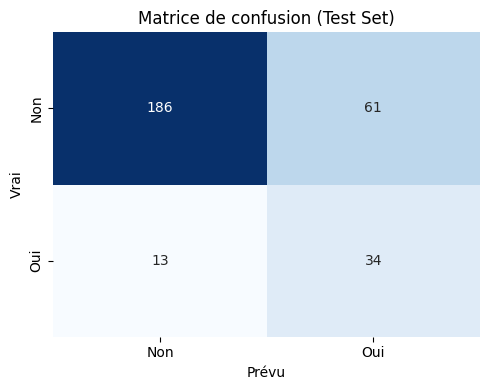

In [28]:
# ---- 1. Prédiction sur le test set ----
model = best_models['xgb_bal_smote']
best_threshold = 0.55

y_proba_test = model.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= best_threshold).astype(int)

# ---- 2. Calcul des scores ----
tableau = metrics_table(y_test, y_pred_test, y_proba_test, "XGB bal + SMOTE", best_threshold)
display(pd.DataFrame([tableau]))

# ---- 3. Matrice de confusion ----
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non','Oui'], yticklabels=['Non','Oui'])
plt.title('Matrice de confusion (Test Set)')
plt.ylabel('Vrai')
plt.xlabel('Prévu')
plt.tight_layout()
plt.show()


## 13. Interprétabilité & Explicabilité

                                              feature  importance
24                                ord__salaire_cat_eq    0.085413
40       cat__poste_departement_Consultant_Consulting    0.072043
51                           bin__nouveau_responsable    0.060110
50                         bin__heure_supplementaires    0.056073
9                      num__niveau_hierarchique_poste    0.055772
13                      num__nombre_participation_pee    0.044508
49                                         bin__genre    0.040071
37         cat__domaine_etude_Transformation Digitale    0.036025
6            num__satisfaction_employee_environnement    0.034080
11                  num__satisfaction_employee_equipe    0.033474
34                   cat__domaine_etude_Infra & Cloud    0.033461
38  cat__poste_departement_Assistant de Direction_...    0.029969
10          num__satisfaction_employee_nature_travail    0.029704
48        cat__poste_departement_Tech Lead_Consulting    0.029602
22        

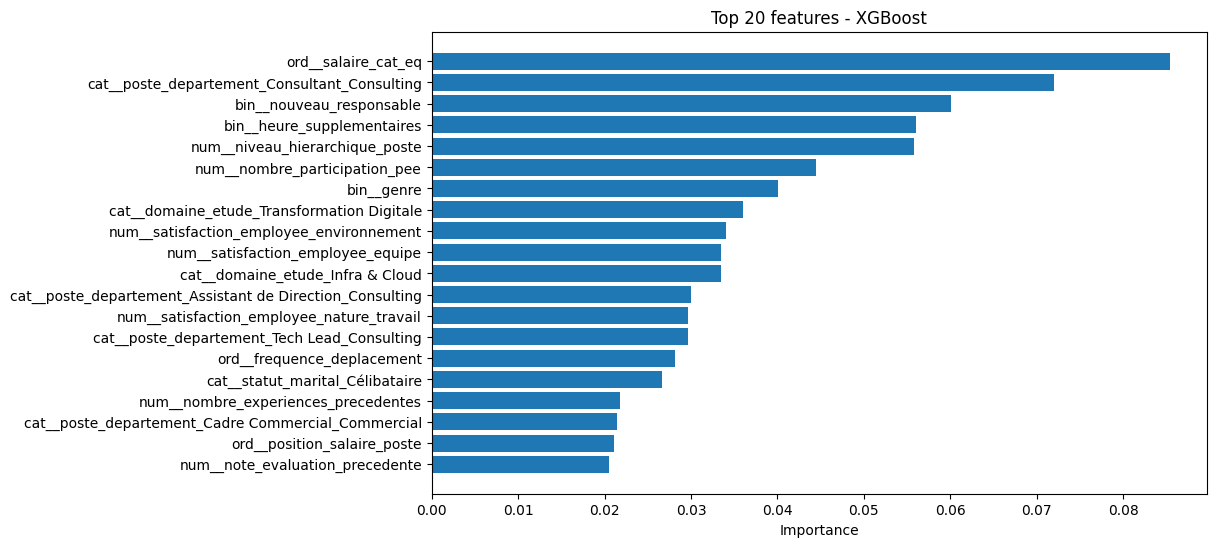

In [29]:
# Récupère le pipeline final (déjà entraîné)
model = best_models['xgb_bal_smote']  # adapte selon ta clé
# Récupère le préprocesseur et le modèle final
preprocessor = model.named_steps['preprocessor']
final_estimator = model.named_steps['clf']

# Applique le preprocessing sur X_test BRUT
X_test_prep = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()
df_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': final_estimator.feature_importances_
}).sort_values('importance', ascending=False)

# Tableau + plot
print(df_importances)
plt.figure(figsize=(10,6))
plt.barh(df_importances["feature"][:20][::-1], df_importances["importance"][:20][::-1])
plt.xlabel("Importance")
plt.title("Top 20 features - XGBoost")
plt.show()


In [43]:
from shapash.explainer.smart_explainer import SmartExplainer

# Récupère le pipeline final
model = best_models['xgb_bal_smote']

# Prétraitement test
X_test_prep = model.named_steps['preprocessor'].transform(X_test)
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
X_test_prep_df = pd.DataFrame(X_test_prep, columns=feature_names, index=X_test.index)

# Cible
Y_test = y_test.copy()  # ou Y_test = y.loc[X_test.index]

# Explainer Shapash
explainer = SmartExplainer(
    model=model.named_steps['clf'],
    features_dict={i: feat for i, feat in enumerate(feature_names)}
)

explainer.compile(
    x=X_test_prep_df,
    y_target=Y_test
)

explainer.run_app()  # Lance le dashboard interactif


INFO: Shap explainer type - shap.explainers.PermutationExplainer()


PermutationExplainer explainer: 295it [00:19, 10.70it/s]                        
INFO:root:Your Shapash application run on http://MacBook-Pro-de-Damien.local:8050/
INFO:root:Use the method .kill() to down your app.


<CustomThread(Thread-7 (<lambda>), started 123145774125056)>

In [30]:
import shap

# Utilise le XGBClassifier "pur" issu du pipeline
xgb_model = model.named_steps['clf']

# Utilise le SHAP Explainer générique (si TreeExplainer bug sur booster, essaye Explainer)
explainer = shap.Explainer(xgb_model, X_test_prep_df)
shap_values = explainer(X_test_prep_df)

# Beeswarm global
shap.plots.beeswarm(shap_values)

# Waterfall sur l'observation 0
shap.plots.waterfall(shap_values[0])


NameError: name 'X_test_prep_df' is not defined

In [31]:
# Calcul des probabilités sur le train (attention : pas de SMOTE sur le test !)
y_proba_train = model.predict_proba(X_train)[:, 1]

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_proba_train)
avg_precision_train = average_precision_score(y_train, y_proba_train)

plt.figure(figsize=(7,5))
plt.plot(recall_train, precision_train, label=f'Train (AP = {avg_precision_train:.2f})', color='orange')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe Précision-Rappel sur le Train')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'precision_recall_curve' is not defined

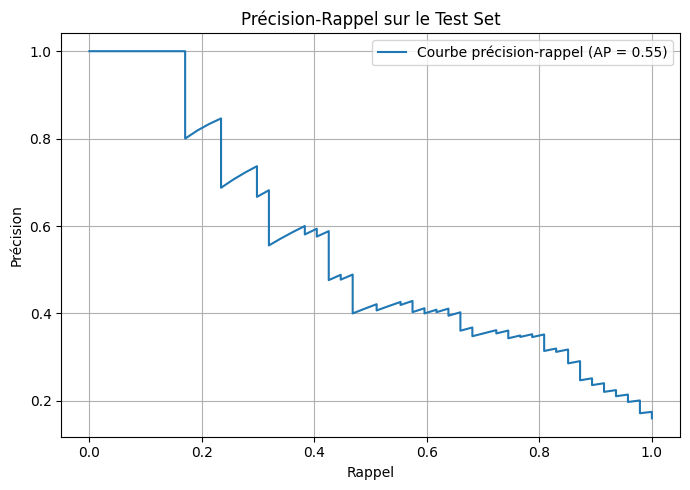

In [32]:
# courbe de précision-rappel

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Prédictions déjà calculées :
# y_proba_test = model.predict_proba(X_test)[:, 1]
# y_test = true labels

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_test)
avg_precision = average_precision_score(y_test, y_proba_test)

plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f'Courbe précision-rappel (AP = {avg_precision:.2f})')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Précision-Rappel sur le Test Set')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


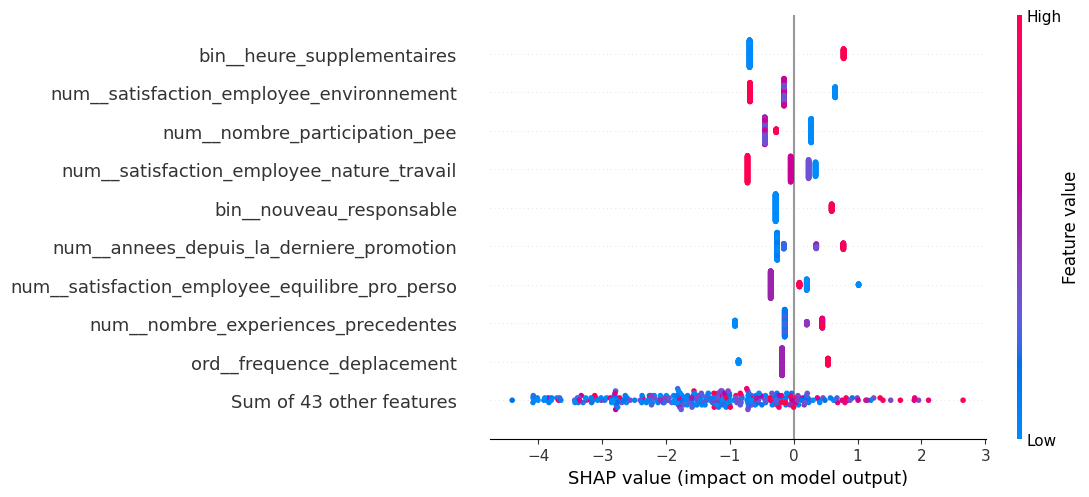

Waterfall SHAP pour un vrai positif (VP)


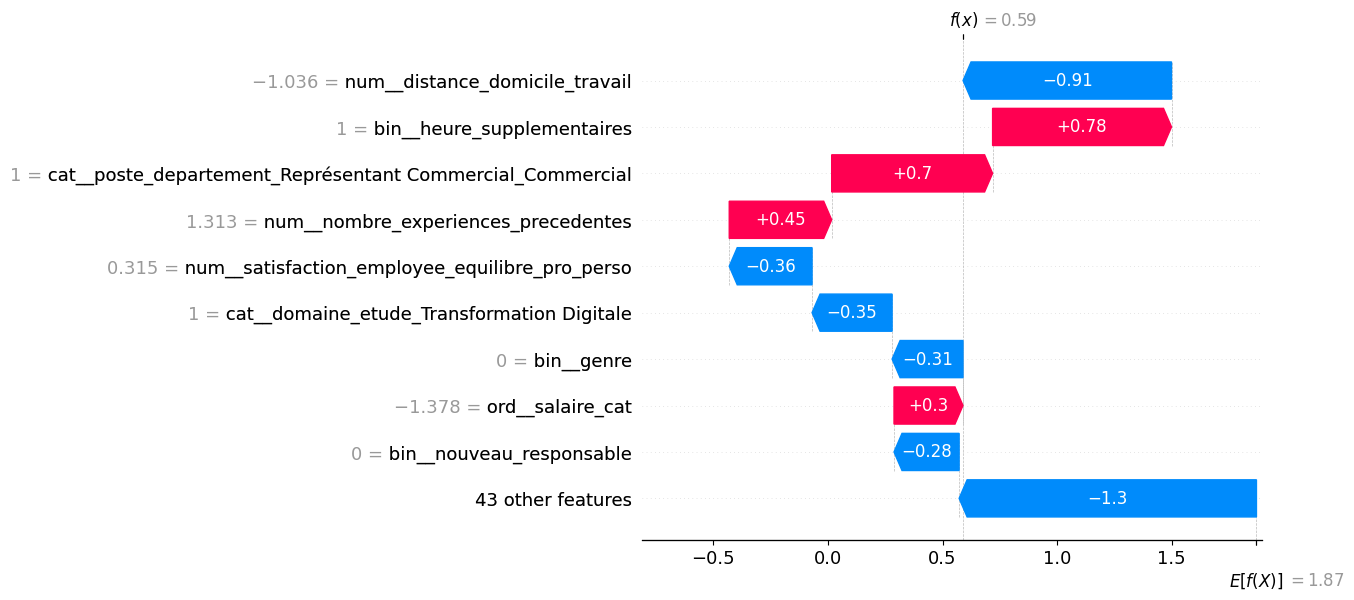

Waterfall SHAP pour un vrai négatif (VN)


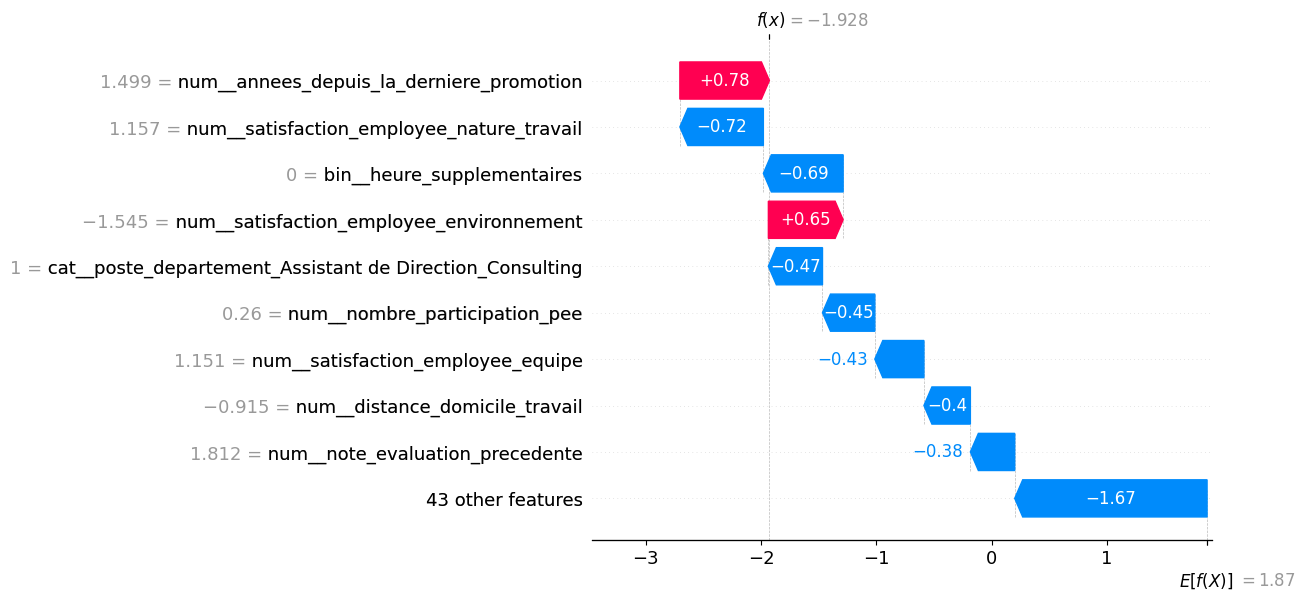


Features et valeurs pour ce VP (20) :
num__age: -0.8910322179079453
num__revenu_mensuel: -0.8156828109558819
num__nombre_experiences_precedentes: 1.3134640254834995
num__annee_experience_totale: -0.8308665378754775
num__annees_dans_l_entreprise: -0.6712379030807707
num__annees_dans_le_poste_actuel: -0.636590169840347
num__satisfaction_employee_environnement: -0.6421634956571192
num__note_evaluation_actuelle: -0.4285414784383637
num__note_evaluation_precedente: -1.0655175809082238
num__niveau_hierarchique_poste: -0.9903844727645228
num__satisfaction_employee_nature_travail: 0.26541703262332444
num__satisfaction_employee_equipe: 0.2322673142799209
num__satisfaction_employee_equilibre_pro_perso: 0.3147738108525613
num__nombre_participation_pee: 2.631806863463094
num__nb_formations_suivies: 0.15751223884965393
num__distance_domicile_travail: -1.0364939915528357
num__niveau_education: 0.08928700076533373
num__annees_depuis_la_derniere_promotion: -0.6713834044229667
num__annes_sous_responsa

In [37]:
import numpy as np
import shap
import pandas as pd
import matplotlib.pyplot as plt

# X_test : DataFrame test d'origine
# model : pipeline scikit-learn (type Pipeline(preprocessor, clf))
# y_test : vérité test
# y_pred_test : prédiction test
# best_threshold : ton seuil utilisé

# 1. Transformation du jeu test via le pipeline, avec extraction des noms réels
X_test_prep = model.named_steps['preprocessor'].transform(X_test)
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
X_test_prep_df = pd.DataFrame(X_test_prep, columns=feature_names)

# 2. Explication SHAP sur cette vraie matrice (bons noms, bon format)
model_xgb = model.named_steps['clf']
explainer = shap.TreeExplainer(model_xgb)
shap_explanation = explainer(X_test_prep_df)  # <-- DataFrame explicit names

# 3. Beeswarm global : vrais noms de variables sur tout le plot
shap.plots.beeswarm(shap_explanation)

# 4. Indices pour un vrai positif et vrai négatif
indices_vp = np.where((y_test == 1) & (y_pred_test == 1))[0]
indices_vn = np.where((y_test == 0) & (y_pred_test == 0))[0]

# 5. Waterfall pour le premier VP et VN
if len(indices_vp) > 0:
    print("Waterfall SHAP pour un vrai positif (VP)")
    shap.plots.waterfall(shap_explanation[indices_vp[0]])
else:
    print("Aucun vrai positif trouvé !")

if len(indices_vn) > 0:
    print("Waterfall SHAP pour un vrai négatif (VN)")
    shap.plots.waterfall(shap_explanation[indices_vn[0]])
else:
    print("Aucun vrai négatif trouvé !")

# 6. (Optionnel) Affichage du mapping valeur-feature pour VP/VN
idx_vp = indices_vp[0] if len(indices_vp) > 0 else None
idx_vn = indices_vn[0] if len(indices_vn) > 0 else None

if idx_vp is not None:
    print(f"\nFeatures et valeurs pour ce VP ({idx_vp}) :")
    for name, value in zip(feature_names, X_test_prep_df.iloc[idx_vp]):
        print(f"{name}: {value}")

if idx_vn is not None:
    print(f"\nFeatures et valeurs pour ce VN ({idx_vn}) :")
    for name, value in zip(feature_names, X_test_prep_df.iloc[idx_vn]):
        print(f"{name}: {value}")


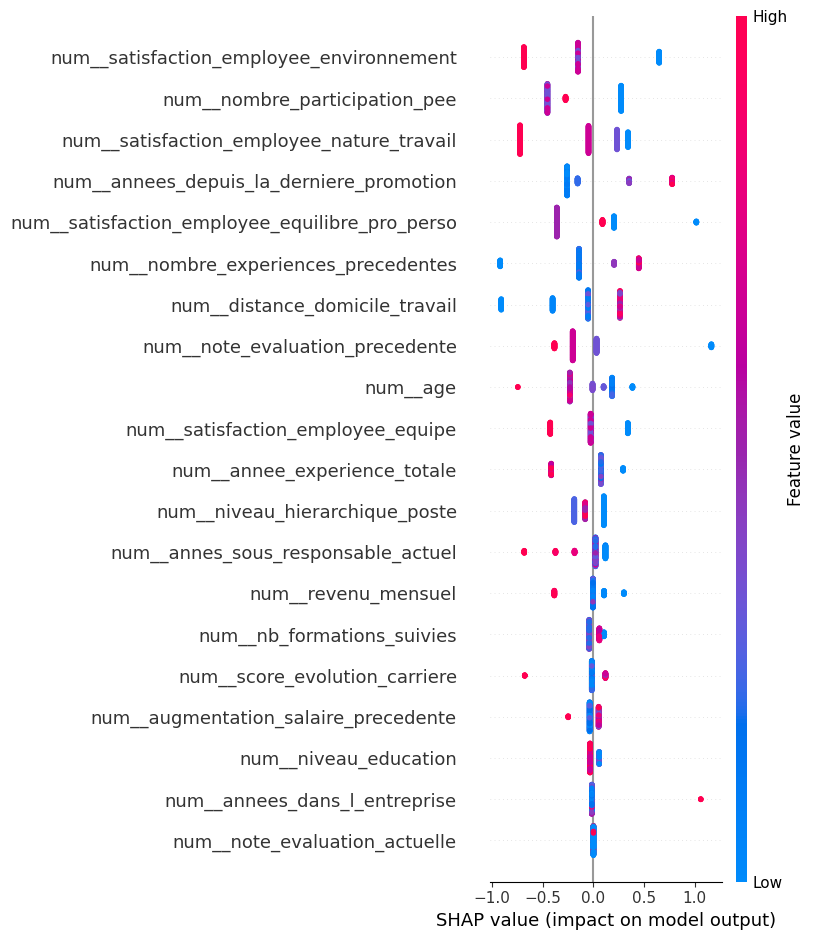

In [39]:
# 1. Explication sur toutes les features (obligatoire)
shap_explanation = explainer(X_test_prep_df)

# 2. Index des features continues dans la matrice transformée
features_continues = [name for name in feature_names if name.startswith("num_")]
indices_continues = [i for i, name in enumerate(feature_names) if name in features_continues]

# 3. Beeswarm filtré : on utilise .values et .feature_names pour filtrer l’affichage
import matplotlib.pyplot as plt

shap.summary_plot(
    shap_explanation.values[:, indices_continues],  # SHAP values filtrés
    X_test_prep_df[features_continues],             # Les features continues
    feature_names=features_continues
)


Colonnes correspondant à 'revenu_mensuel' : ['num__revenu_mensuel']


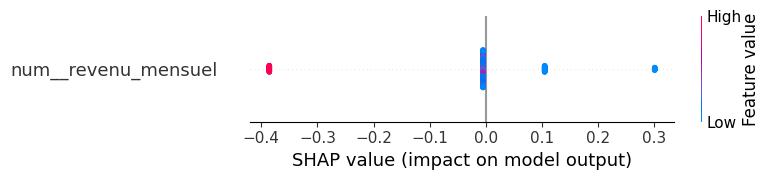

In [40]:
# 1. Explication SHAP sur toutes les features transformées
shap_explanation = explainer(X_test_prep_df)
feature_names = X_test_prep_df.columns

# 2. Trouver le(s) nom(s) exact(s) de la colonne pour 'revenu_mensuel' après pipeline
revenu_col = [name for name in feature_names if 'revenu_mensuel' in name]
print("Colonnes correspondant à 'revenu_mensuel' :", revenu_col)

# 3. Si c’est une variable numérique (scalée), il ne devrait y avoir qu’une seule colonne
if len(revenu_col) == 1:
    idx_rev = list(feature_names).index(revenu_col[0])
    shap.summary_plot(
        shap_explanation.values[:, [idx_rev]],
        X_test_prep_df[revenu_col],
        feature_names=revenu_col
    )
else:
    print("Plusieurs colonnes trouvées (OneHot/Ordinal), vérifier le mapping :", revenu_col)
